# Data Mining Lab 3
#### Team 2:  Patricia Goresen, Jeffrey Lancon, Brychan Manry, George C Sturrock

## Business Understanding I
The source of baseball data for this lab is the Sean Lahman Baseball Database [ http://www.seanlahman.com/baseball-archive/statistics/]. Often cited as the most complete baseball database, the data set includes twenty-seven data tables and millions of records covering most non-proprietary baseball data pertaining to offense, fielding, pitching, payroll, player demographics, team statistics, manager data and much more.  

In previous assignments, the team focused on predicting MLB team playoff appearances using team level data and predicting player positions using on field player statistics.

For this Lab, we will use unsupervised clustering techniques, to gain insight into MLB pitcher’s statistics, in an attempt to discover cluster patterns that differentiate, but more importantly, group pitchers that are similar to one another. Finding pitchers that are similar to elite pitchers would be to asset to general managers in making staffing decisions regarding pitchers. Many times, these decisions are made on non-technical basis, such as personality, media attention, fame level, which can lead to mangers paying-up for the image and not the stats.  The clustering tools can assist with answering those questions by showing similar pitchers who may be suitable replacements, making it possible to find that 'diamond-in-the-rough'.

In Lab 3, the team will focus on the tasks of: a) developing multiple clustering techniques for comparison, b) determining the best model using comparison metrics, c) explore clusters, to determine if they do in produce clusters that are representative of what we are interested in.  The clustering algorithms will be evaluated by comparing their silhouette coefficients. The silhouette coefficient is a common measure used to determine the optimal algorithm. The algorithm that maximizes this coefficient will be used; a high silhouette coefficient indicates good cluster cohesion and good cluster separation. This is important as we want our clusters to have strong, accurate clusters.


A full list of variables and their meanings are provided in *Data Description* section of this notebook.

-----

## Data Understanding - Part 1

This lab will focus on the analysis of five specific tables containing player level details in the Lahman Baseball Database:  Batting, Fielding, Pitching, Salaries, and People.  The names of the different tables accurately describe the contents.  For example, the Batting table contains offensive statics per year for each player.  The tables are at different grains.  The ultimate intention is to have a single data frame accurately combining all relevant features of the four tables.  The methods used to achieve this goal will be presented below.  

In addition to the Lahman’s datasets, two additional datasets will be merged into the final dataset, MinSalary.csv and Inflation.csv.  The MinSalary.csv is a listing of minimum salaries for MLB players by year.  The Inflation.csv is a salary inflation index from 1985 to 2017 that was created using CPI data courtesy of Minneapolis Federal Reserve.

### Import Data

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

batting = pd.read_csv('./data/Batting.csv')
fielding = pd.read_csv('./data/Fielding.csv')
salaries = pd.read_csv('./data/Salaries.csv')
inflation = pd.read_csv('./data/Inflation.csv')
minSalary = pd.read_csv('./data/MinimumSalaries.csv')
pitching = pd.read_csv('./data/PitchingIn.csv')
people = pd.read_csv('./data/People.csv')

#Rename Column Names to standardize with Lahman database columns and remove spaces
inflation = inflation.rename(index=str, columns={'Year': 'yearID'})
minSalary = minSalary.rename(index=str, columns={'Year': 'yearID', 'MinSalaries ': 'MinSalaries'})

#print('Batting', batting.info())
#print('Fielding', fielding.info())
#print('Salaries', salaries.info())
#print('Inflation', inflation.info())
#print('Minimum Salary', minSalary.info())
#print('Pitching', PitchingIn.info())

In [3]:
## Go back and convert to table ##
#teamNullCols = pd.DataFrame({'n Missing' : teamNullCols, '% Missing' : ((teamNullCols / teams2.shape[0])*100).round(2)#.astype(str) + "%"})

print("Shape of DataFrames:", "\nBatting:", batting.shape, "\nFielding:", fielding.shape, "\nSalaries:", salaries.shape, "\nInflation:", inflation.shape, "\nMinimum Salary:", minSalary.shape, "\nPitching:", pitching.shape)

Shape of DataFrames: 
Batting: (104324, 24) 
Fielding: (138838, 18) 
Salaries: (26428, 5) 
Inflation: (33, 4) 
Minimum Salary: (51, 2) 
Pitching: (45806, 30)


### Subsetting by Year

As evident from the difference in data frame sizes displayed above, a one to one match does not exist between the four major and two minor source tables. The process of creating data frames which can be merged into a single data frame will begin with row level filtering. Only records from the 1985 season and greater will be used for analysis in this assignment. 1985 was chosen for two reasons.  

a)	MLB Salary data only goes back to 1985.  
b)	The evolution of the game and it players have changed quite a bit since beginning of professional baseball. Selecting only records from the 1985 season and forward provides a 32-year data set while eliminating data that would likely lead to erroneous results.

In [8]:
#awards = awards[awards.yearID > 1984]
batting = batting[batting.yearID > 1984]
fielding = fielding[fielding.yearID > 1984]
salaries = salaries[salaries.yearID > 1984]
minSalary = minSalary[minSalary.yearID > 1984]
pitching = pitching[pitching.yearID > 1984]

print("Shape of DataFrames:", "\nBatting:", batting.shape, "\nFielding:", fielding.shape, "\nSalaries:", salaries.shape, "\nInflation:", inflation.shape, "\nMinimum Salary:", minSalary.shape, "\nPitching:", pitching.shape)

Shape of DataFrames: 
Batting: (42071, 24) 
Fielding: (54560, 18) 
Salaries: (26428, 5) 
Inflation: (33, 4) 
Minimum Salary: (33, 2) 
Pitching: (20822, 30)


### Batting

The Batting table will be the driver for the overall consolidated data frame.  In other words, fielding, salaries and awards will be merged into the Batting data frame.  First, categorical variables, such as Team and League ID, which offer limited predictive or structural value will be dropped from the data frame.  The 'G_old' variable is the void of values and will be dropped as well.

In [9]:
batting = batting.drop(['teamID', 'lgID', 'G_old', 'G_batting', 'stint'], axis=1)
#Drop rows with no basic statistics are recorded in a year
#batting = batting[(batting[['AB', 'BB']] != 0).all(axis=1)]
batting = batting[(batting[['AB']] != 0).all(axis=1)]
batting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30823 entries, 1 to 104305
Data columns (total 19 columns):
playerID    30823 non-null object
yearID      30823 non-null int64
G           30823 non-null int64
AB          30823 non-null int64
R           30823 non-null int64
H           30823 non-null int64
2B          30823 non-null int64
3B          30823 non-null int64
HR          30823 non-null int64
RBI         30823 non-null float64
SB          30823 non-null float64
CS          30823 non-null float64
BB          30823 non-null int64
SO          30823 non-null float64
IBB         30823 non-null float64
HBP         30823 non-null float64
SH          30823 non-null float64
SF          30823 non-null float64
GIDP        30823 non-null float64
dtypes: float64(9), int64(9), object(1)
memory usage: 4.7+ MB


There are approximately 1,800 instances where a player has more than one record per year in the batting data frame.  This is to be expected as player trades and multiple stints in the major league do occur in a single season.  These instances will be consolidated into a single row per 'playerID'. 

In [10]:
#Identify Instances where a player has more than one batting record per year.
df = batting.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.G > 1]
#print(df)

#Consolidate and Aggreagate
#print(batting.groupby(['yearID', 'playerID']).sum().reset_index())
battingFinal = batting.groupby(['yearID', 'playerID']).sum().reset_index()

#print(battingFinal)
print('  BattingFinal Info\n')
print(battingFinal.info())

print('\n\n   BattingFinal Statistics\n')
battingFinal.describe().round(2)

  BattingFinal Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28904 entries, 0 to 28903
Data columns (total 19 columns):
yearID      28904 non-null int64
playerID    28904 non-null object
G           28904 non-null int64
AB          28904 non-null int64
R           28904 non-null int64
H           28904 non-null int64
2B          28904 non-null int64
3B          28904 non-null int64
HR          28904 non-null int64
RBI         28904 non-null float64
SB          28904 non-null float64
CS          28904 non-null float64
BB          28904 non-null int64
SO          28904 non-null float64
IBB         28904 non-null float64
HBP         28904 non-null float64
SH          28904 non-null float64
SF          28904 non-null float64
GIDP        28904 non-null float64
dtypes: float64(9), int64(9), object(1)
memory usage: 4.2+ MB
None


   BattingFinal Statistics



yearID         G        AB         R         H        2B        3B  \
count  28904.0  28904.00  28904.00  28904.00  28904.00  28904.00  28904.00   
mean    2001.9     64.41    179.44     23.96     46.88      9.03      1.01   
std        9.3     49.93    199.23     30.29     56.41     11.48      1.89   
min     1985.0      1.00      1.00      0.00      0.00      0.00      0.00   
25%     1994.0     22.00     11.00      1.00      2.00      0.00      0.00   
50%     2002.0     48.00     77.00      8.00     17.00      3.00      0.00   
75%     2010.0    108.00    328.00     41.00     84.00     16.00      1.00   
max     2017.0    163.00    716.00    152.00    262.00     59.00     23.00   

             HR       RBI        SB        CS        BB        SO       IBB  \
count  28904.00  28904.00  28904.00  28904.00  28904.00  28904.00  28904.00   
mean       5.23     22.71      3.40      1.46     17.25     34.58      1.40   
std        8.56     29.92      7.71      2.73     23.20     38.02      3.18   
min        0.00      0.00      0.00      0.00      0.00      0.00      0.00   
25%        0.00      0.00      0.00      0.00      0.00      4.00      0.00   
50%        1.00      7.00      0.00      0.00      6.00     20.00      0.00   
75%        7.00     38.00      3.00      2.00     28.00     56.00      1.00   
max       73.00    165.00    110.00     29.00    232.00    223.00    120.00   

            HBP        SH        SF      GIDP  
count  28904.00  28904.00  28904.00  28904.00  
mean       1.61      1.74      1.48      4.03  
std        2.86      2.80      2.23      5.31  
min        0.00      0.00      0.00      0.00  
25%        0.00      0.00      0.00      0.00  
50%        0.00      0.00      0.00      1.00  
75%        2.00      2.00      2.00      7.00  
max       35.00     39.00     17.00     35.00

After consolidating duplicate entries, 28,904 unique records with 19 variable remain.

In [11]:
print("Index:", battingFinal.index)
print("\nColumns:")
battingFinal.columns

Index: RangeIndex(start=0, stop=28904, step=1)

Columns:


Index(['yearID', 'playerID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP'],
      dtype='object')

### Fielding
The Fielding table contains most of the common defensive statistics in baseball.  The granularity of this data set is by player, year, stint and position.  It is commonplace for players to play more than one position over the course of a season.  However, most players have a primary position in which they play a majority of the time.  There is also the concept of a utility player.  This a player who has no primary position and plays a significant number of games in many positions.  The end objective is to produce a final fielding data set summarized at the player and year granularity.

In [8]:
#fielding = fielding[fielding.POS != 'P']
print('  Fielding Info\n')
fielding.info()
print('\n\n   Fielding Statistics\n')
fielding.describe().round(2)

  Fielding Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54560 entries, 0 to 138837
Data columns (total 18 columns):
playerID    54560 non-null object
yearID      54560 non-null int64
stint       54560 non-null int64
teamID      54560 non-null object
lgID        54560 non-null object
POS         54560 non-null object
G           54560 non-null int64
GS          54545 non-null float64
InnOuts     54545 non-null float64
PO          54560 non-null int64
A           54560 non-null int64
E           54560 non-null float64
DP          54560 non-null int64
PB          3651 non-null float64
WP          0 non-null float64
SB          3651 non-null float64
CS          3651 non-null float64
ZR          0 non-null float64
dtypes: float64(8), int64(6), object(4)
memory usage: 7.9+ MB


   Fielding Statistics



yearID     stint         G        GS   InnOuts        PO         A  \
count  54560.00  54560.00  54560.00  54545.00  54545.00  54560.00  54560.00   
mean    2002.05      1.08     35.47     25.02    670.33     74.49     28.64   
std        9.42      0.29     40.09     39.60   1035.11    175.18     71.38   
min     1985.00      1.00      1.00      0.00      0.00      0.00      0.00   
25%     1994.00      1.00      6.00      0.00     55.00      2.00      1.00   
50%     2002.00      1.00     20.00      6.00    202.00      8.00      5.00   
75%     2010.00      1.00     50.00     31.00    667.00     55.00     18.00   
max     2017.00      4.00    163.00    162.00   4388.00   1597.00    570.00   

              E        DP       PB   WP       SB       CS   ZR  
count  54560.00  54560.00  3651.00  0.0  3651.00  3651.00  0.0  
mean       1.89      6.91     3.07  NaN    26.91    11.55  NaN  
std        3.56     19.55     3.56  NaN    26.72    12.35  NaN  
min        0.00      0.00     0.00  NaN     0.00     0.00  NaN  
25%        0.00      0.00     0.00  NaN     4.00     1.00  NaN  
50%        0.00      1.00     2.00  NaN    19.00     8.00  NaN  
75%        2.00      3.00     5.00  NaN    43.00    18.00  NaN  
max       42.00    176.00    35.00  NaN   155.00    89.00  NaN

From the above fielding data frame statistics, it's easy to see WP (wild pitch) and ZR (zone rating) variables are missing values in their entirety.  The two columns will be dropped from the data frame.  To maintain consistency with the batting data frame, team and league will be dropped as well.  

In [12]:
fielding = fielding.drop(['teamID', 'lgID', 'WP', 'ZR'], axis=1)

There are numerous missing values in the columns 'PB', 'SB' and 'CS'.  This makes sense as these are statistics specific to catchers. Example: 'CS' - times player caught opponent stealing.  

The data was spot checked to verify these are accurate missing values.  The missing values will be replaced with zeros.

In [13]:
fielding.fillna(value={'PB': 0, 'SB': 0, 'ZR': 0, 'CS': 0}, inplace = True)
#print(fielding.info())
print('   Fielding Statistics\n')
fielding.describe().round(2)

   Fielding Statistics



yearID     stint         G        GS   InnOuts        PO         A  \
count  54560.00  54560.00  54560.00  54545.00  54545.00  54560.00  54560.00   
mean    2002.05      1.08     35.47     25.02    670.33     74.49     28.64   
std        9.42      0.29     40.09     39.60   1035.11    175.18     71.38   
min     1985.00      1.00      1.00      0.00      0.00      0.00      0.00   
25%     1994.00      1.00      6.00      0.00     55.00      2.00      1.00   
50%     2002.00      1.00     20.00      6.00    202.00      8.00      5.00   
75%     2010.00      1.00     50.00     31.00    667.00     55.00     18.00   
max     2017.00      4.00    163.00    162.00   4388.00   1597.00    570.00   

              E        DP        PB        SB        CS  
count  54560.00  54560.00  54560.00  54560.00  54560.00  
mean       1.89      6.91      0.21      1.80      0.77  
std        3.56     19.55      1.20      9.64      4.30  
min        0.00      0.00      0.00      0.00      0.00  
25%        0.00      0.00      0.00      0.00      0.00  
50%        0.00      1.00      0.00      0.00      0.00  
75%        2.00      3.00      0.00      0.00      0.00  
max       42.00    176.00     35.00    155.00     89.00

There were 9772 instances where a player played multiple positions in the same year. These multiple position player's stats will be merge into a single record per player per year. 

In [14]:
#Identify Players who played multiple positions per year.
df = fielding.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.stint > 1]
#print(df)
print(df.shape)

(9772, 14)


An important step of data cleansing, aggregation and merging process is to identify the primary position for each player.  If a player played multiple positions within a year, the Primary Position 'primePOS', for analysis purposes, will be the position at which the player played the most games.

In [15]:
#Identify Primary Postion per Player per Year Based on Max Games at a position.
df = fielding.groupby(['playerID', 'yearID', 'POS']).sum().reset_index()
df = df.groupby(['playerID', 'yearID', 'POS'])['G'].max().reset_index()
#df = df.groupby(['playerID', 'yearID', 'POS']).max()['G']
df = df.sort_values(by=['playerID', 'yearID', 'G'], ascending=[True, True, False])
#print(df)
#print(df.describe())

primePOS = pd.DataFrame()
svPlayerID = ''
svYearID = 0

for index, row in df.iterrows():
    #print (row["playerID"], row["yearID"], row['POS'], row['G'])
    if (svPlayerID != row['playerID'] or svYearID != row['yearID']):
        primePOS = primePOS.append({'playerID': row['playerID'], 'yearID': row['yearID'], 'Primary': row['POS']}, ignore_index=True)
        #print(svPlayerID, row["playerID"], svYearID, row["yearID"], row['POS'], row['G'])
        svPlayerID = row['playerID']
        svYearID = row['yearID']
    else:
        continue
  

In [13]:
print(primePOS.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38453 entries, 0 to 38452
Data columns (total 3 columns):
Primary     38453 non-null object
playerID    38453 non-null object
yearID      38453 non-null float64
dtypes: float64(1), object(2)
memory usage: 901.3+ KB
None


After consolidating multiple position player's yearly stats, 38,453 unique records with 14 variables remain in the Fielding data frame.

In [16]:
#Condense Fielding Dataframe into one row per player per year.
fielding = fielding.groupby(['playerID', 'yearID']).sum().reset_index()

#Merge Primary Position into condensed Fielding data frame
fieldingFinal = pd.merge(fielding, primePOS, on=['playerID', 'yearID'], how='left')

#print(fieldingFinal)
#print(fieldingFinal.describe())
print('  FieldingFinal Info\n')
print(fieldingFinal.info())
print('\n\n   FieldingFinal Statistics')
fieldingFinal.describe().round(2)

  FieldingFinal Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38453 entries, 0 to 38452
Data columns (total 14 columns):
playerID    38453 non-null object
yearID      38453 non-null int64
stint       38453 non-null int64
G           38453 non-null int64
GS          38453 non-null float64
InnOuts     38453 non-null float64
PO          38453 non-null int64
A           38453 non-null int64
E           38453 non-null float64
DP          38453 non-null int64
PB          38453 non-null float64
SB          38453 non-null float64
CS          38453 non-null float64
Primary     38453 non-null object
dtypes: float64(6), int64(6), object(2)
memory usage: 4.4+ MB
None


   FieldingFinal Statistics


yearID     stint         G        GS   InnOuts        PO         A  \
count  38453.00  38453.00  38453.00  38453.00  38453.00  38453.00  38453.00   
mean    2002.03      1.53     50.32     35.49    950.86    105.69     40.64   
std        9.39      1.21     45.21     46.26   1210.39    207.30     87.09   
min     1985.00      1.00      1.00      0.00      0.00      0.00      0.00   
25%     1994.00      1.00     14.00      0.00    114.00      2.00      2.00   
50%     2002.00      1.00     34.00     14.00    337.00     11.00      8.00   
75%     2010.00      2.00     73.00     52.00   1407.00    123.00     26.00   
max     2017.00     23.00    195.00    163.00   4388.00   1597.00    570.00   

              E        DP        PB        SB        CS  
count  38453.00  38453.00  38453.00  38453.00  38453.00  
mean       2.68      9.81      0.29      2.55      1.10  
std        4.32     23.57      1.43     11.52      5.14  
min        0.00      0.00      0.00      0.00      0.00  
25%        0.00      0.00      0.00      0.00      0.00  
50%        1.00      1.00      0.00      0.00      0.00  
75%        3.00      4.00      0.00      0.00      0.00  
max       42.00    176.00     35.00    155.00     89.00

### Salaries

The Salaries data set contains yearly salaries for players beginning in 1985.  This data will be consolidated into one observation per player per year, similar to the fielding and batting data sets.  League and teamID will be dropped from this data set as well since those variables are extraneous in this data set.
There are also numerous salary entries missing; These missing values will be addressed below.

In [19]:
#Drop League and Team
salaries = salaries.drop(['teamID', 'lgID'], axis=1)

#Summarize salaries at the year and player level
salariesFinal = salaries.groupby(['playerID', 'yearID']).sum().reset_index()

#print(salariesFinal)
print('\n\n  SalariesFinal Statistics')
salariesFinal.describe().round(2)



  SalariesFinal Statistics


yearID       salary
count  26323.00     26323.00
mean    2000.90   2093953.45
std        8.91   3460182.39
min     1985.00         0.00
25%     1994.00    300000.00
50%     2001.00    554391.00
75%     2009.00   2362500.00
max     2016.00  33000000.00

### People
The People table contains demographic data about players.  For this study, physical characteristics such as height, weight, throwing hand and batting hand may be of interest in the analysis. This data set is relatively clean.

In [20]:
people = people[['playerID', 'weight', 'height', 'bats', 'throws']]
print('  People Info\n')
people.info()
people.describe().round(2)

  People Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 5 columns):
playerID    19370 non-null object
weight      18533 non-null float64
height      18615 non-null float64
bats        18185 non-null object
throws      18391 non-null object
dtypes: float64(2), object(3)
memory usage: 756.7+ KB


weight    height
count  18533.00  18615.00
mean     186.58     72.29
std       21.64      2.61
min       65.00     43.00
25%      170.00     71.00
50%      185.00     72.00
75%      200.00     74.00
max      320.00     83.00

### Merging Batting, Fielding, Salaries and People

The Batting, Fielding, Salaries and People data sets will be consolidated using playerID and yearID as indexes.  The Player data set will be created which will contain all the merged data sets.

In [21]:
#Merge Batting and Fielding

player = pd.merge(battingFinal, fieldingFinal, on=['playerID', 'yearID'], how='left')

#Drop Pitchers from merged dataframe
player = player[player.Primary != 'P']

#Merge Salaries
player = pd.merge(player, salariesFinal, on=['playerID', 'yearID'], how='left')

#Merge People
player = pd.merge(player, people, on=['playerID'], how='left')

#print(player)
print('  Player Info - Post Batting/Fielding Merge\n')
print(player.info())
print('\n\n   Player Statistics - Post Batting/Fielding Merge')
player.describe().round(2)

  Player Info - Post Batting/Fielding Merge

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 36 columns):
yearID      19820 non-null int64
playerID    19820 non-null object
G_x         19820 non-null int64
AB          19820 non-null int64
R           19820 non-null int64
H           19820 non-null int64
2B          19820 non-null int64
3B          19820 non-null int64
HR          19820 non-null int64
RBI         19820 non-null float64
SB_x        19820 non-null float64
CS_x        19820 non-null float64
BB          19820 non-null int64
SO          19820 non-null float64
IBB         19820 non-null float64
HBP         19820 non-null float64
SH          19820 non-null float64
SF          19820 non-null float64
GIDP        19820 non-null float64
stint       19536 non-null float64
G_y         19536 non-null float64
GS          19536 non-null float64
InnOuts     19536 non-null float64
PO          19536 non-null float64
A           19536 non-nul

yearID       G_x        AB         R         H       2B        3B  \
count  19820.00  19820.00  19820.00  19820.00  19820.00  19820.0  19820.00   
mean    2001.49     80.33    253.70     34.49     67.25     13.0      1.46   
std        9.43     51.67    200.25     31.37     57.56     11.9      2.13   
min     1985.00      1.00      1.00      0.00      0.00      0.0      0.00   
25%     1993.00     30.00     64.75      7.00     14.00      2.0      0.00   
50%     2002.00     82.00    215.00     25.00     53.00     10.0      1.00   
75%     2010.00    129.00    432.00     57.00    114.00     21.0      2.00   
max     2017.00    163.00    716.00    152.00    262.00     59.0     23.00   

             HR       RBI      SB_x    ...           PO         A         E  \
count  19820.00  19820.00  19820.00    ...     19536.00  19536.00  19536.00   
mean       7.59     32.69      4.95    ...       203.73     70.97      4.65   
std        9.44     31.41      8.89    ...       254.99    113.86      5.28   
min        0.00      0.00      0.00    ...         0.00      0.00      0.00   
25%        1.00      6.00      0.00    ...        37.00      3.00      1.00   
50%        4.00     23.00      1.00    ...       120.00     14.00      3.00   
75%       11.00     52.00      6.00    ...       259.00     80.00      7.00   
max       73.00    165.00    110.00    ...      1597.00    570.00     42.00   

             DP        PB      SB_y      CS_y       salary    weight    height  
count  19536.00  19536.00  19536.00  19536.00     13683.00  19820.00  19820.00  
mean      18.63      0.57      5.03      2.16   2261094.58    195.99     72.68  
std       30.56      1.97     15.78      7.05   3688277.47     21.83      2.11  
min        0.00      0.00      0.00      0.00         0.00    140.00     66.00  
25%        1.00      0.00      0.00      0.00    300000.00    180.00     71.00  
50%        3.00      0.00      0.00      0.00    625000.00    195.00     73.00  
75%       22.00      0.00      0.00      0.00   2525000.00    210.00     74.00  
max      176.00     35.00    155.00     89.00  33000000.00    320.00     80.00  

[8 rows x 32 columns]

### Merge Inflation and Minimum Salary Data with Player DataFrame

In [22]:
player = pd.merge(player, inflation, on=['yearID'], how='left')
player = pd.merge(player, minSalary, on=['yearID'], how='left')

print('  Player Info - Post Inflation/minSalary Merge\n')
print(player.info())
print('\n\n   Player Statistics - Post Inflation/minSalary Merge')
player.describe().round(2)
#print(list(player))

  Player Info - Post Inflation/minSalary Merge

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 40 columns):
yearID                 19820 non-null int64
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-n

yearID       G_x        AB         R         H       2B        3B  \
count  19820.00  19820.00  19820.00  19820.00  19820.00  19820.0  19820.00   
mean    2001.49     80.33    253.70     34.49     67.25     13.0      1.46   
std        9.43     51.67    200.25     31.37     57.56     11.9      2.13   
min     1985.00      1.00      1.00      0.00      0.00      0.0      0.00   
25%     1993.00     30.00     64.75      7.00     14.00      2.0      0.00   
50%     2002.00     82.00    215.00     25.00     53.00     10.0      1.00   
75%     2010.00    129.00    432.00     57.00    114.00     21.0      2.00   
max     2017.00    163.00    716.00    152.00    262.00     59.0     23.00   

             HR       RBI      SB_x     ...             DP        PB  \
count  19820.00  19820.00  19820.00     ...       19536.00  19536.00   
mean       7.59     32.69      4.95     ...          18.63      0.57   
std        9.44     31.41      8.89     ...          30.56      1.97   
min        0.00      0.00      0.00     ...           0.00      0.00   
25%        1.00      6.00      0.00     ...           1.00      0.00   
50%        4.00     23.00      1.00     ...           3.00      0.00   
75%       11.00     52.00      6.00     ...          22.00      0.00   
max       73.00    165.00    110.00     ...         176.00     35.00   

           SB_y      CS_y       salary    weight    height  Annual Average  \
count  19536.00  19536.00     13683.00  19820.00  19820.00        19820.00   
mean       5.03      2.16   2261094.58    195.99     72.68          541.25   
std       15.78      7.05   3688277.47     21.83      2.11          125.67   
min        0.00      0.00         0.00    140.00     66.00          323.20   
25%        0.00      0.00    300000.00    180.00     71.00          434.10   
50%        0.00      0.00    625000.00    195.00     73.00          540.50   
75%        0.00      0.00   2525000.00    210.00     74.00          655.30   
max      155.00     89.00  33000000.00    320.00     80.00          736.60   

       Mult2017  MinSalaries  
count  19820.00     19820.00  
mean       1.44    263269.65  
std        0.37    160399.76  
min        1.00     60000.00  
25%        1.12    109000.00  
50%        1.36    200000.00  
75%        1.70    400000.00  
max        2.28    535000.00  

[8 rows x 35 columns]

### Uniqueness

A review of the number of unique values per column shown below show little evidence there are issues with low or near zero variance.  Attributes with relatively low uniqueness counts such as bats, throws, triple (3B), stint and minimum salary per year for MLB players (MinSalaries) are to be expected.  

In [23]:
df = player.nunique(dropna = False)
print(df)

yearID                   33
playerID               3497
G_x                     163
AB                      694
R                       146
H                       231
2B                       59
3B                       23
HR                       65
RBI                     157
SB_x                     81
CS_x                     29
BB                      148
SO                      206
IBB                      43
HBP                      33
SH                       29
SF                       18
GIDP                     34
stint                    22
G_y                     189
GS                      165
InnOuts                4198
PO                     1270
A                       525
E                        40
DP                      160
PB                       28
SB_y                    130
CS_y                     65
Primary                   7
salary                 2359
weight                   96
height                   15
bats                      3
throws              

### Missing Values

Missing values per columns are summarized in the table shown below.  Many of these attributes result from merging the batting data frame with the fielding data frame.  These missing values have been spot checked and appear to be valid.  It is common to have a player not record any fielding statistics during a season.  
For example, every game played in an American League stadium will have two designated hitters in the starting lineup.  These players typically hit for their team's pitcher and do not have to play in the field.  Additionally, the National League employs the double switch as a strategy.  This can also lead to players hitting without fielding.  There are a variety of additional scenarios which could lead to this as well.  The missing values for each column will be evaluated and handled individually.
 

In [24]:
df = player.isnull().sum()
df = df[df > 0]
df = pd.DataFrame({
    'n Missing' : df,
    '% Missing' : ((df / player.shape[0])*100).round(2)})

cm = sns.light_palette("red", as_cmap=True)
df.style.background_gradient(cmap=cm)

#### Filling Missing Values

Stint will be filled with 1 when missing since that's the minimum amount possible.  The remaining columns with high rates of missing values will be filled with zeros as these are instances where the player did not field a position or information was unavailable.  Salary will be filled with zeros in this step, but will receive additional treatment below.

In [25]:
colls = []
colls = ['G_y', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'SB_y', 'CS_y', 'salary']


for c in colls:
    player[c].fillna(0, inplace=True)
    
#Fill missing stint with 1
player['stint'].fillna(1, inplace = True)
    
#Fill missing Primary Position with "DH"
player['Primary'].fillna('DH', inplace = True)

##### Missing Salary 

In the Lahman Baseball Database, players who do not start the year on an MLB roster do not have salaries listed in the table.  The league minimum salary will be used for these instances.  Looking up individual contracts details for each player with a missing salary would be counterproductive.  These instances were filled with zero in the step above.  

A second salary column named "adjSalary2" will be created to fill the zeros with the league minimum salary for that year with inflation adjusted values.  

In [26]:
#Inflation Adjusted Salary
player['adjSalary'] = (player.salary * player.Mult2017)
player['adjMinSalaries'] = (player.MinSalaries * player.Mult2017)

player['adjSalary2'] = np.where(player['adjSalary'] == 0, player['adjMinSalaries'], player['adjSalary'])


print('  Player Info - Post Missing Value Adjustments\n')
print(player.info())
print('\n\n  Player Data Set - Post Missing Value Adjustments')
player.head()

  Player Info - Post Missing Value Adjustments

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 43 columns):
yearID                 19820 non-null int64
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-n

yearID   playerID  G_x   AB   R   H  2B  3B  HR   RBI     ...      height  \
0    1985  adamsri02   54  121  12  23   3   1   2  10.0     ...        74.0   
1    1985  aguaylu01   91  165  27  46   7   3   6  21.0     ...        69.0   
2    1985  aikenwi01   12   20   2   4   1   0   1   5.0     ...        75.0   
3    1985  allenga01   14   34   2   4   1   0   0   3.0     ...        71.0   
4    1985  almonbi01   88  244  33  66  17   0   6  29.0     ...        75.0   

   bats  throws  Annual Average  AnnualPercentChange  Mult2017  MinSalaries  \
0     R       R           323.2                3.50%     2.279      60000.0   
1     R       R           323.2                3.50%     2.279      60000.0   
2     L       R           323.2                3.50%     2.279      60000.0   
3     R       R           323.2                3.50%     2.279      60000.0   
4     R       R           323.2                3.50%     2.279      60000.0   

   adjSalary  adjMinSalaries  adjSalary2  
0        0.0        136740.0    136740.0  
1   540123.0        136740.0    540123.0  
2        0.0        136740.0    136740.0  
3        0.0        136740.0    136740.0  
4   581145.0        136740.0    581145.0  

[5 rows x 43 columns]

#### Final Check for Missing Values

A final check to see if any variables have missing values.

In [27]:
print(player.isnull().sum())

yearID                 0
playerID               0
G_x                    0
AB                     0
R                      0
H                      0
2B                     0
3B                     0
HR                     0
RBI                    0
SB_x                   0
CS_x                   0
BB                     0
SO                     0
IBB                    0
HBP                    0
SH                     0
SF                     0
GIDP                   0
stint                  0
G_y                    0
GS                     0
InnOuts                0
PO                     0
A                      0
E                      0
DP                     0
PB                     0
SB_y                   0
CS_y                   0
Primary                0
salary                 0
weight                 0
height                 0
bats                   0
throws                 0
Annual Average         0
AnnualPercentChange    0
Mult2017               0
MinSalaries            0


#### Subset by Number of Games to Reduce Outliers

As shown in the box plot below, the interquartile bottom limit for games played from the batting data is 30.  This value will be used to subset the data and reduce noise in the data set.  It is common for players to be called up from the minor leagues and/or optioned down to the minor leagues during the year.  Players, with very short stints, often play multiple positions or no position and their yearly statistics are not representative of a full-time player.  MLB player's union has a minimum of 43 games-played for a player to qualify for the union pension plan, so 30 was deemed to be an appropriate minimum number of games.

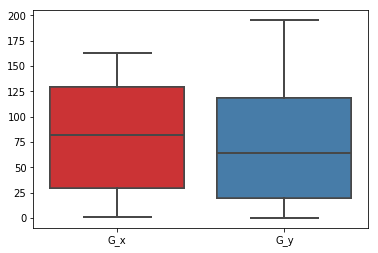

In [43]:
sns.boxplot(data=player[['G_x', 'G_y']], palette="Set1")
plt.show()

### New Variables

Baseball statistics often reference stats that are a combination of basic field stats: Batting Average 'Bavg', Slugging 'Slug', On-base-percentage 'OBP',...
While these stats are based on stats already included in our data set, it was decided to include these additional variables, as there may be some additional information garnered from these particular combinations.

In [28]:
#Batting Average
player['Bavg'] = (player.H / player.AB)

#Slugging
player['Slug'] = ((player.H - player['2B'] - player['3B'] - player.HR) + (player['2B']*2) + (player['3B']*3) + player.HR*4) / player.AB

#OBP
player['OBP'] = (player.H + player.BB + player.HBP) / (player.AB + player.BB + player.HBP + player.SF)

#Fielding Percentage - the sum of putouts and assists divided by the number of total chances (putouts + assists + errors)
player['FPct'] = (player.PO + player.A) / (player.PO + player.A + player.E)
player['FPct'].fillna(0, inplace = True)


### Player Data Set - Final Version

The final version of the Player data set consist of 19,820 observations and 46 variables

In [29]:
print(player.info())
print('\n\n  Player Data Set - Final')
player.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 47 columns):
yearID                 19820 non-null int64
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null float64
stint                  19820 non-nul

yearID   playerID  G_x   AB   R   H  2B  3B  HR   RBI    ...     \
0    1985  adamsri02   54  121  12  23   3   1   2  10.0    ...      
1    1985  aguaylu01   91  165  27  46   7   3   6  21.0    ...      
2    1985  aikenwi01   12   20   2   4   1   0   1   5.0    ...      
3    1985  allenga01   14   34   2   4   1   0   0   3.0    ...      
4    1985  almonbi01   88  244  33  66  17   0   6  29.0    ...      

   AnnualPercentChange  Mult2017  MinSalaries  adjSalary  adjMinSalaries  \
0                3.50%     2.279      60000.0        0.0        136740.0   
1                3.50%     2.279      60000.0   540123.0        136740.0   
2                3.50%     2.279      60000.0        0.0        136740.0   
3                3.50%     2.279      60000.0        0.0        136740.0   
4                3.50%     2.279      60000.0   581145.0        136740.0   

   adjSalary2      Bavg      Slug       OBP      FPct  
0    136740.0  0.190083  0.280992  0.228346  0.964539  
1    540123.0  0.278788  0.466667  0.377551  0.965251  
2    136740.0  0.200000  0.400000  0.291667  0.000000  
3    136740.0  0.117647  0.147059  0.117647  1.000000  
4    581145.0  0.270492  0.413934  0.329630  0.976959  

[5 rows x 47 columns]

### Pitching Data Set

Pitching data set will stand separate from the position "player" data set.  Pitchers are evaluated and measured on different metrics and statistics when compared to position players; therefore, analysis of pitcher data should be distinct from position players.

The original Pitching Data set has a total of 20,822 observations and 30 variables.

Similar to the batting table, more than one record per player may exist in a year.  This could be due to being called up from or sent down to the minor leagues during the year, injuries, or trades.  There are 1,643 instances where a player has more than one stint/record per year in the Lahman database.  These multiple stats observation per year will be merged into a single observation per pitcher per year.   

In [30]:
#Identify Instances where a player has more than one batting record per year.
df = pitching.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.G > 1]

print('Orignal Pitching Data Set Dimensions',pitching.shape)

print('\nInstances of Multiple records per year:',df.shape)

Orignal Pitching Data Set Dimensions (20822, 30)

Instances of Multiple records per year: (1643, 30)


An important step of data cleansing, aggregation and merging process is to identify pitchers with multiple records within a given year.  These multiple observation will be merged into a single observation per pitcher per year.

The aggregated Pitcher's data set contains 19,188 observations and 30 variables

In [31]:
#Consolidate and Aggreagate
#print(pitching.groupby(['yearID', 'playerID']).sum().reset_index())
pitching = pitching.groupby(['yearID', 'playerID']).sum().reset_index()

#print(pitching)
print(' Pitching Data Set Dims - Post Duplicate Cleansing',pitching.shape)
#print(pitching.info())
print('\n Pitcher Statistics - Post Duplicate Cleansing')
pitching.describe().round(2)

 Pitching Data Set Dims - Post Duplicate Cleansing (19118, 28)

 Pitcher Statistics - Post Duplicate Cleansing


yearID     stint         W         L         G        GS        CG  \
count  19118.00  19118.00  19118.00  19118.00  19118.00  19118.00  19118.00   
mean    2002.60      1.18      3.97      3.97     28.34      7.93      0.46   
std        9.34      0.62      4.56      3.97     21.17     11.57      1.44   
min     1985.00      1.00      0.00      0.00      1.00      0.00      0.00   
25%     1995.00      1.00      0.00      1.00     10.00      0.00      0.00   
50%     2003.00      1.00      2.00      3.00     26.00      0.00      0.00   
75%     2011.00      1.00      6.00      6.00     40.00     14.00      0.00   
max     2017.00     10.00     27.00     21.00     94.00     40.00     24.00   

            SHO        SV    IPouts    ...          IBB        WP       HBP  \
count  19118.00  19118.00  19118.00    ...     19118.00  19118.00  19118.00   
mean       0.15      2.00    212.59    ...         2.12      2.59      2.43   
std        0.54      6.82    194.83    ...         2.37      2.88      2.79   
min        0.00      0.00      0.00    ...         0.00      0.00      0.00   
25%        0.00      0.00     56.00    ...         0.00      0.00      0.00   
50%        0.00      0.00    160.00    ...         1.00      2.00      2.00   
75%        0.00      0.00    292.75    ...         3.00      4.00      4.00   
max       10.00     62.00    881.00    ...        20.00     26.00     21.00   

             BK       BFP        GF         R        SH        SF      GIDP  
count  19118.00  19118.00  19118.00  19118.00  19118.00  19118.00  19118.00  
mean       0.37    304.71      7.47     36.23      2.63      2.24      6.09  
std        0.89    273.36     12.02     32.15      3.03      2.33      6.30  
min        0.00      1.00      0.00      0.00      0.00      0.00      0.00  
25%        0.00     85.00      0.00     12.00      0.00      0.00      1.00  
50%        0.00    231.00      2.00     25.00      2.00      2.00      4.00  
75%        0.00    421.00     10.00     53.00      4.00      3.00      9.00  
max       16.00   1231.00     79.00    160.00     22.00     17.00     41.00  

[8 rows x 27 columns]

#### Merge People and Salary with Pitching

As was done with the Player data set, People and Salaries data sets will be merged to the Pitching data set.

In [32]:
#Merge People table with Pitching.
pitching = pd.merge(pitching, people, on=['playerID'], how='left')

#Merge Salary data table with Pitching
pitching = pd.merge(pitching, salariesFinal, on=['yearID', 'playerID'], how='left')
pitching = pd.merge(pitching, inflation, on=['yearID'], how='left')
pitching = pd.merge(pitching, minSalary, on=['yearID'], how='left')

##Drop and Rename Pitching Columns after merging
#pitching = pitching.drop(['yearID_y'], axis=1)
#pitching = pitching.rename(index=str, columns={'yearID_x': 'yearID'})

print(' Pitching Data Set Dims - Post People/Salary Merge',pitching.shape)
print('\n Pitcher Statistics - Post People/Salary Merge')
pitching.head().round(2)

 Pitching Data Set Dims - Post People/Salary Merge (19118, 37)

 Pitcher Statistics - Post People/Salary Merge


yearID   playerID  stint   W  L   G  GS  CG  SHO  SV     ...       GIDP  \
0    1985   aasedo01      1  10  6  54   0   0    0  14     ...       13.0   
1    1985  abregjo01      1   1  1   6   5   0    0   0     ...        3.0   
2    1985  ackerji01      1   7  2  61   0   0    0  10     ...       16.0   
3    1985  agostju01      1   4  3  54   0   0    0   1     ...        4.0   
4    1985  aguilri01      1  10  7  21  19   2    0   0     ...        8.0   

   weight  height  bats  throws    salary  Annual Average  \
0   190.0    75.0     R       R       NaN           323.2   
1   185.0    72.0     R       R       NaN           323.2   
2   210.0    74.0     R       R  170000.0           323.2   
3   190.0    74.0     L       L  147500.0           323.2   
4   195.0    76.0     R       R       NaN           323.2   

   AnnualPercentChange  Mult2017  MinSalaries  
0                3.50%      2.28      60000.0  
1                3.50%      2.28      60000.0  
2                3.50%      2.28      60000.0  
3                3.50%      2.28      60000.0  
4                3.50%      2.28      60000.0  

[5 rows x 37 columns]

### Minimum Games Pitched - Outlier Reduction

A minimum games played rule of 30 games per year is defined for the position player data frame.  A similar rule will be implemented for pitchers.  From a biomechanical perspective, the pitching motion is incredibly stressful on a pitcher's arm and shoulder.  As such, pitchers typically play far fewer games per year than position players.  For example, a starting pitcher typically plays once every five games.  A middle reliever could play every other game.  The box plot below shows the 1st interquartile range is 10 games.  This will be implemented as the minimum number of games rule for pitchers.

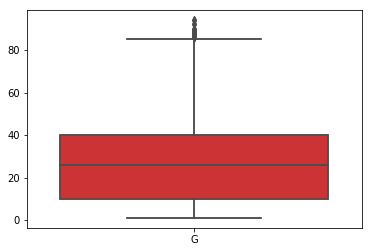

count    19118.00
mean        28.34
std         21.17
min          1.00
25%         10.00
50%         26.00
75%         40.00
max         94.00
Name: G, dtype: float64

In [50]:
sns.boxplot(data=pitching[['G']], palette="Set1")
plt.show()
pitching.G.describe().round(2)

After the minimum games pitched rule is implemented, there are 14,473 records in the pitching data set.  

In [33]:
pitching = pitching[pitching.G > 9]
print(' Pitching Data Set Dims - Post Min Game Rule',pitching.shape)
print('\n Pitcher Statistics - Post Min Game Rule')
pitching.describe().round(2)

 Pitching Data Set Dims - Post Min Game Rule (14473, 37)

 Pitcher Statistics - Post Min Game Rule


yearID     stint         W         L         G        GS        CG  \
count  14473.00  14473.00  14473.00  14473.00  14473.00  14473.00  14473.00   
mean    2002.48      1.22      5.10      4.98     35.97      9.98      0.60   
std        9.33      0.68      4.69      4.02     18.72     12.56      1.63   
min     1985.00      1.00      0.00      0.00     10.00      0.00      0.00   
25%     1995.00      1.00      1.00      2.00     21.00      0.00      0.00   
50%     2003.00      1.00      4.00      4.00     32.00      1.00      0.00   
75%     2011.00      1.00      8.00      8.00     49.00     21.00      0.00   
max     2017.00     10.00     27.00     21.00     94.00     40.00     24.00   

            SHO        SV    IPouts     ...              R        SH  \
count  14473.00  14473.00  14473.00     ...       14473.00  14473.00   
mean       0.19      2.63    269.54     ...          45.10      3.33   
std        0.61      7.74    190.80     ...          31.97      3.15   
min        0.00      0.00     10.00     ...           0.00      0.00   
25%        0.00      0.00    127.00     ...          20.00      1.00   
50%        0.00      0.00    207.00     ...          34.00      2.00   
75%        0.00      1.00    390.00     ...          69.00      5.00   
max       10.00     62.00    881.00     ...         160.00     22.00   

             SF      GIDP    weight    height       salary  Annual Average  \
count  14473.00  14473.00  14473.00  14473.00     10684.00        14473.00   
mean       2.80      7.71    204.53     74.42   2008882.44          554.47   
std        2.38      6.40     22.65      2.12   3236706.17          124.10   
min        0.00      0.00    150.00     66.00     60000.00          323.20   
25%        1.00      3.00    190.00     73.00    303500.00          457.90   
50%        2.00      6.00    200.00     74.00    600000.00          552.80   
75%        4.00     11.00    220.00     76.00   2350000.00          676.00   
max       17.00     41.00    315.00     83.00  33000000.00          736.60   

       Mult2017  MinSalaries  
count  14473.00     14473.00  
mean       1.41    279595.65  
std        0.36    160837.24  
min        1.00     60000.00  
25%        1.09    109000.00  
50%        1.33    300000.00  
75%        1.61    414000.00  
max        2.28    535000.00  

[8 rows x 33 columns]

### Missing Values

Missing values per columns are summarized in the table shown below.  Twenty six percent of the salary information is missing from the data set. As previously stated, salary information for players not on a major league team's roster at the beginning of the year are not included in the Lahman database.  Missing salary data will be handled in the same manner as the player's data set.

In [34]:
df = pitching.isnull().sum()
df = df[df > 0]
print(df)
df = pd.DataFrame({
    'n Missing' : df,
    '% Missing' : ((df / pitching.shape[0])*100).round(2)})

cm = sns.light_palette("red", as_cmap=True)
df.style.background_gradient(cmap=cm)

salary    3789
dtype: int64


##### Missing Salary 

In the Lahman Baseball Database, players who do not start the year on an MLB roster do not have salaries listed in the table.  The league minimum salary will be used for these instances.  

A second salary column named "adjSalary2" will be created to fill the zeros with the league minimum salary for that year with inflation adjusted values. 

In [35]:
#Fill missing values with 0.  
pitching['salary'].fillna(0, inplace=True)

#Inflation Adjusted Salary
pitching['adjSalary'] = (pitching.salary * pitching.Mult2017)
pitching['adjMinSalaries'] = (pitching.MinSalaries * pitching.Mult2017)

pitching['adjSalary2'] = np.where(pitching['adjSalary'] == 0, pitching['adjMinSalaries'], pitching['adjSalary'])

print('  Pitching Shape - Post Missing Value Adjustments\n',pitching.shape)
print('\n\n  Pitching Data Set - Post Missing Value Adjustments')
pitching.head()

  Pitching Shape - Post Missing Value Adjustments
 (14473, 40)


  Pitching Data Set - Post Missing Value Adjustments


yearID   playerID  stint   W   L   G  GS  CG  SHO  SV     ...      bats  \
0    1985   aasedo01      1  10   6  54   0   0    0  14     ...         R   
2    1985  ackerji01      1   7   2  61   0   0    0  10     ...         R   
3    1985  agostju01      1   4   3  54   0   0    0   1     ...         L   
4    1985  aguilri01      1  10   7  21  19   2    0   0     ...         R   
5    1985  alexado01      1  17  10  36  36   6    1   0     ...         R   

   throws    salary  Annual Average  AnnualPercentChange  Mult2017  \
0       R       0.0           323.2                3.50%     2.279   
2       R  170000.0           323.2                3.50%     2.279   
3       L  147500.0           323.2                3.50%     2.279   
4       R       0.0           323.2                3.50%     2.279   
5       R  875000.0           323.2                3.50%     2.279   

   MinSalaries  adjSalary  adjMinSalaries  adjSalary2  
0      60000.0        0.0        136740.0    136740.0  
2      60000.0   387430.0        136740.0    387430.0  
3      60000.0   336152.5        136740.0    336152.5  
4      60000.0        0.0        136740.0    136740.0  
5      60000.0  1994125.0        136740.0   1994125.0  

[5 rows x 40 columns]

### Uniqueness

The table below shown there is little concern for attributes with near zero variance.  Stint is expected to have little variance as it is rare for a pitcher to have more than two stints per year.  Four stints in a season is the maximum observed in the remaining data.  People attributes such as bats and throws should have a low number of unique values.

In [36]:
df = pitching.nunique(dropna = False)
df

yearID                   33
playerID               3168
stint                     4
W                        26
L                        21
G                        83
GS                       41
CG                       21
SHO                      10
SV                       57
IPouts                  792
H                       273
ER                      139
HR                       47
BB                      129
SO                      282
BAOpp                   884
ERA                    1545
IBB                      20
WP                       27
HBP                      22
BK                       16
BFP                    1070
GF                       75
R                       153
SH                       23
SF                       18
GIDP                     41
weight                   92
height                   18
bats                      3
throws                    3
salary                 2023
Annual Average           33
AnnualPercentChange      23
Mult2017            

#### MLB Players - Number of Years in League

The amount of time a player has been in the league can play an important role in a player’s salary. Rookie contracts are non-negotiable for the first few years (e.g., close to the league minimum), and then arbitrated after that until the player makes it to free agency (usually ~5 years). Once in free agency a player can go to the highest bidding team and salaries can increase significantly.  

To account for artificial limits early on and any potential relationship with free-agency contracts later in careers we calculated the season number ("seasonNum") variable by taking the difference between the current season year and a player's MLB debut year. This is a good proxy for time in the league for players. Even if a player is bumped back and forth between the minors and majors, once they get their MLB debut the clock starts ticking on their rookie contract and time to free agency.


In [34]:
# Load Career Dates from 'People' File
careerDates = pd.read_csv('./data/People.csv')[['playerID', 'debut']]
careerDates['debut'] = pd.to_datetime(careerDates['debut'], errors='coerce')
careerDates = careerDates.dropna() # some very old players have different date formats
careerDates['debutYear'] = careerDates['debut'].dt.year.astype(int)

# Join debutYear to player DF
player = player.set_index('playerID').join(careerDates[['playerID', 'debutYear']].set_index('playerID'))
player.reset_index(level=0, inplace=True)
player['seasonNum'] = (player['yearID'] - player['debutYear']) + 1

#### Write Data set to CSV - Unscaled
To give model developers flexibility to analyze and experiment with scaled and unscaled data, Unscaled CSV files will be created for both 'player' and 'pitching'.

In [35]:
player.to_csv('./data/player.csv', sep=',', encoding='utf-8')
pitching.to_csv('./data/pitching.csv', sep=',', encoding='utf-8')

#Players with no Salary
#playerNoSalary = player[player.salary > 0]
#playerNoSalary.to_csv('./data/playerNoSal.csv', sep=',', encoding='utf-8')

### Scaling Data Variables

To minimize the risk of variables being overly influential due to the units of measurement, as was determined in prior assignments, some of the baseball data variables required scaling. Variables will be scaled to have a mean value of 0 and standard deviation of 1.

Attributes such as; ratios and cumulative integers, will not be scaled due to the nature of their value.

In [36]:
#Baseball Data must be scaled due to the combination of percentages and cummulative statistics.  
from sklearn.preprocessing import StandardScaler
#Save key attributes which cannot be scaled prior to scaling
df = player[['yearID', 'playerID', 'Primary', 'bats', 'throws']]
dfp = pitching[['yearID', 'playerID', 'bats', 'throws']]

#Drop Attributes which are not needed, can't be scaled or shouldn't be scaled
player = player.drop(['AnnualPercentChange', 'Mult2017', "Annual Average", 'yearID', 'playerID', 'Primary', 'bats', 'throws'], axis=1)
pitching = pitching.drop(['AnnualPercentChange', 'Mult2017', "Annual Average", 'yearID', 'playerID', 'bats', 'throws'], axis=1)

colNames = player.columns
colNamesP = pitching.columns

#Scale data
scaler = StandardScaler()
playerScaled = scaler.fit_transform(player)
playerScaled = pd.DataFrame(playerScaled, columns=colNames)

pitchingScaled = scaler.fit_transform(pitching)
pitchingScaled = pd.DataFrame(pitchingScaled, columns=colNamesP)

#Merge Primary Position back into the dataframe
#player = pd.concat([df, player], axis=1, ignore_index=True)
playerScaled['yearID'] = df['yearID']
playerScaled['playerID'] = df['playerID']
playerScaled['Primary'] = df['Primary']
playerScaled['bats'] = df['bats']
playerScaled['throws'] = df['throws']

player['yearID'] = df['yearID']
player['playerID'] = df['playerID']
player['Primary'] = df['Primary']
player['bats'] = df['bats']
player['throws'] = df['throws']

pitchingScaled['yearID'] = dfp['yearID']
pitchingScaled['playerID'] = dfp['playerID']
pitchingScaled['bats'] = dfp['bats']
pitchingScaled['throws'] = dfp['throws']

pitching['yearID'] = dfp['yearID']
pitching['playerID'] = dfp['playerID']
pitching['bats'] = dfp['bats']
pitching['throws'] = dfp['throws']

#print(player.info())
#print(player.describe())
#print(playerScaled.info())
#print(playerScaled.describe())
#print(pitching.info())
#print(pitching.describe())
#print(pitchingScaled.info())
#print(pitchingScaled.describe())

print('\n  Player Shape - Non-Scaled\n',player.shape)
print('\n\n  Player Data Set - Non-Scaled')
player.head()


  Player Shape - Non-Scaled
 (19820, 46)


  Player Data Set - Non-Scaled


G_x   AB   R   H  2B  3B  HR   RBI  SB_x  CS_x   ...        Slug       OBP  \
0    1    1   0   0   0   0   0   0.0   0.0   0.0   ...    0.000000  0.000000   
1    9   17   1   2   0   0   0   0.0   0.0   1.0   ...    0.117647  0.210526   
2    5    3   0   0   0   0   0   0.0   0.0   0.0   ...    0.000000  0.400000   
3   19   38   8  10   1   0   1   2.0   0.0   0.0   ...    0.368421  0.263158   
4   89  244  33  68  14   1  12  41.0   3.0   3.0   ...    0.491803  0.298450   

       FPct  debutYear  seasonNum  yearID   playerID  Primary  bats  throws  
0  1.000000       2001          1    2001   abadan01       1B     L       L  
1  0.972973       2001          3    2003   abadan01       1B     L       L  
2  0.000000       2001          6    2006   abadan01       DH     L       L  
3  1.000000       1997          1    1997  abbotje01       OF     R       L  
4  0.970588       1997          2    1998  abbotje01       OF     R       L  

[5 rows x 46 columns]

In [37]:
print('\n  Player Shape - Scaled\n',playerScaled.shape)
print('\n\n  Player Data Set - Scaled')
playerScaled.head()


  Player Shape - Scaled
 (19820, 46)


  Player Data Set - Scaled


G_x        AB         R         H        2B        3B        HR  \
0 -1.535340 -1.261958 -1.099318 -1.168429 -1.092388 -0.686485 -0.804102   
1 -1.380511 -1.182054 -1.067442 -1.133680 -1.092388 -0.686485 -0.804102   
2 -1.457925 -1.251970 -1.099318 -1.168429 -1.092388 -0.686485 -0.804102   
3 -1.186975 -1.077180 -0.844309 -0.994685 -1.008355 -0.686485 -0.698177   
4  0.167777 -0.048418 -0.047404  0.013031  0.084066 -0.216968  0.467001   

        RBI      SB_x      CS_x   ...        Slug       OBP      FPct  \
0 -1.040719 -0.556564 -0.689948   ...   -2.652335 -3.624710  0.291502   
1 -1.040719 -0.556564 -0.364529   ...   -1.811925 -1.138578  0.111875   
2 -1.040719 -0.556564 -0.689948   ...   -2.652335  1.098941 -6.354691   
3 -0.977044 -0.556564 -0.689948   ...   -0.020523 -0.517045  0.291502   
4  0.264627 -0.219032  0.286310   ...    0.860857 -0.100280  0.096025   

   debutYear  seasonNum  yearID   playerID  Primary  bats  throws  
0   0.430043  -1.151333    2001   abadan01       1B     L       L  
1   0.430043  -0.693599    2003   abadan01       1B     L       L  
2   0.430043  -0.006998    2006   abadan01       DH     L       L  
3   0.051505  -1.151333    1997  abbotje01       OF     R       L  
4   0.051505  -0.922466    1998  abbotje01       OF     R       L  

[5 rows x 46 columns]

In [38]:
print('\n  Pitching Shape - Non-Scaled\n',pitching.shape)
print('\n\n  Pitching Data Set - Non-Scaled')
pitching.head()


  Pitching Shape - Non-Scaled
 (14473, 37)


  Pitching Data Set - Non-Scaled


stint   W   L   G  GS  CG  SHO  SV  IPouts    H   ...    height    salary  \
0      1  10   6  54   0   0    0  14     264   83   ...      75.0       0.0   
2      1   7   2  61   0   0    0  10     259   86   ...      74.0  170000.0   
3      1   4   3  54   0   0    0   1     181   45   ...      74.0  147500.0   
4      1  10   7  21  19   2    0   0     367  118   ...      76.0       0.0   
5      1  17  10  36  36   6    1   0     782  268   ...      75.0  875000.0   

   MinSalaries  adjSalary  adjMinSalaries  adjSalary2  yearID   playerID  \
0      60000.0        0.0        136740.0    136740.0    1985   aasedo01   
2      60000.0   387430.0        136740.0    387430.0    1985  ackerji01   
3      60000.0   336152.5        136740.0    336152.5    1985  agostju01   
4      60000.0        0.0        136740.0    136740.0    1985  aguilri01   
5      60000.0  1994125.0        136740.0   1994125.0    1985  alexado01   

   bats  throws  
0     R       R  
2     R       R  
3     L       L  
4     R       R  
5     R       R  

[5 rows x 37 columns]

In [39]:
print('\n  Pitching Shape - Scaled\n',pitchingScaled.shape)
print('\n\n  Pitching Data Set - Scaled')
pitchingScaled.head()


  Pitching Shape - Scaled
 (14473, 37)


  Pitching Data Set - Scaled


stint         W         L         G        GS        CG       SHO  \
0 -0.327478  1.045778  0.252964  0.963127 -0.794470 -0.367902 -0.319754   
1 -0.327478  0.405905 -0.741778  1.337044 -0.794470 -0.367902 -0.319754   
2 -0.327478 -0.233967 -0.493092  0.963127 -0.794470 -0.367902 -0.319754   
3 -0.327478  1.045778  0.501649 -0.799628  0.718085  0.860106 -0.319754   
4 -0.327478  2.538814  1.247705  0.001624  2.071425  3.316120  1.323056   

         SV    IPouts         H   ...      height    salary  MinSalaries  \
0  1.469589 -0.029057 -0.096950   ...    0.273211 -0.508269    -1.365376   
1  0.952545 -0.055264 -0.049841   ...   -0.198818 -0.450003    -1.365376   
2 -0.210802 -0.464091 -0.693665   ...   -0.198818 -0.457715    -1.365376   
3 -0.340063  0.510805  0.452656   ...    0.745240 -0.508269    -1.365376   
4 -0.340063  2.685976  2.808108   ...    0.273211 -0.208372    -1.365376   

   adjSalary  adjMinSalaries  adjSalary2  yearID   playerID  bats  throws  
0  -0.554574       -1.444914   -0.552978  1985.0   aasedo01     R       R  
1  -0.439460       -1.444914   -0.477321     NaN        NaN   NaN     NaN  
2  -0.454695       -1.444914   -0.492796  1985.0  ackerji01     R       R  
3  -0.554574       -1.444914   -0.552978  1985.0  agostju01     L       L  
4   0.037926       -1.444914    0.007572  1985.0  aguilri01     R       R  

[5 rows x 37 columns]

#### Write Data set to CSV - Scaled

To give model developers flexibility to analyze and experiment with scaled and unscaled data, CSV files with scaled data will be created for both players 'playerscale' and pitching 'pitchingscale'.

In [40]:
playerScaled.to_csv('./data/playerscale.csv', sep=',', encoding='utf-8')
pitchingScaled.to_csv('./data/pitchingscale.csv', sep=',', encoding='utf-8')

#Players with Salary
#playerNoSalaryScale = player[playerScaled.salary > 0]
#playerNoSalaryScale.to_csv('./data/playerNoSalscale.csv', sep=',', encoding='utf-8')

#### Write Data set to PKL - Scaled and UnScaled

The same scaled and unscaled data sets will be saved using .pkl data formats as well.

In [41]:
# Save pandas data frames as pickles
player.to_pickle("./analysisdata/player.pkl")
#playerNoSalary.to_pickle("./analysisdata/playerNoSal.pkl")
playerScaled.to_pickle("./analysisdata/playerScaled.pkl")
#playerNoSalaryScale.to_pickle("./analysisdata/playerNoSalScale.pkl")
pitching.to_pickle("./analysisdata/pitching.pkl")
pitchingScaled.to_pickle("./analysisdata/pitchingScaled.pkl")


### Data Description (Including New Features)
The overall strategy for the data preparation is to provide data files to the model developers which offer ultimate flexibility and do not restrict or discard data unless necessary.  There are two final data sets.

The first is the player data set.  It is the combination of batting, fielding, salary and inflation data per player per year.  Much effort was spent assuring only one summarized record per player per year exists in this file.  

The second is the pitchers data set.  It is a combination pitching, salary and inflation data per player per year.

Both scaled and unscaled versions of the data sets have been developed so the modeler can choose the most appropriate data set for their analysis needs.  

Finally, all files are available to the modelers as .CSV, .pkl or in memory as pandas data frames if the modeler chooses to build from this notebook.  

#### Position Player File
The table below is a full description of the position Player Data Set.


| Attribute      | Category      | Type     | DF_Type | Description                                                            |
|----------------|---------------|----------|---------|---------------------------------------------------------------------------------------|
| yearID         | Informational | Interval | int64   | The professional baseball season.                                                     |
| playerID       | Informational | nominal  | object  | Unique identifier for the player.                                                     |
| Primary        | Informational | nominal  | object  | The player's primary position during the year.                                        |
| G_x            | Informational | Interval | int64   | The number of games where the player batted during the specified year.                |
| R              | Batting       | Interval | int64   | Total runs scored by the player during the year.                                      |
| AB             | Batting       | Interval | int64   | Total at bats by the player during the year.                                          |
| H              | Batting       | Interval | int64   | Total hist by the player during the year.                                             |
| 2B             | Batting       | Interval | int64   | Total doubles by the player during the year.                                          |
| 3B             | Batting       | Interval | int64   | Total triples by the player during the year.                                          |
| HR             | Batting       | Interval | int64   | Total home runs for the player during the year.                                       |
| RBI            | Batting       | Interval | int64   | Total Runs Batted In by the player during the year.                                   |
| BB             | Batting       | Interval | float64 | Total bases on balls or walks by the player during the year.                          |
| SO             | Batting       | Interval | float64 | Total strikeouts by the player during the year.                                       |
| SB_x           | Batting       | Interval | float64 | Total stolen bases by the player during the year.                                     |
| CS_x           | Batting       | Interval | float64 | Total time the player was caught stealing during the year.                            |
| HBP            | Batting       | Interval | float64 | Total number of times the player was hit by a pitch during the year.                  |
| SF             | Batting       | Interval | float64 | Total number of sacrifice flies by the player during the year.                        |
| GIDP           | Batting       | Interval | float64 | The number of times the player grounded into a double play during the year.           |
| stint          | Fielding      | Interval | float64 | The number of stints the player had during the year.                                  |
| G_y            | Fielding      | Interval | float64 | The number of games the player played in the field.                                   |
| GS             | Fielding      | Interval | float64 | The number of games started in the field by the player.                               |
| InnOuts        | Fielding      | Interval | float64 | The number of outs the player played during the year.                                 |
| PO             | Fielding      | Interval | float64 | The number of put outs by the player during the year.                                 |
| A              | Fielding      | Interval | float64 | The number of assists by the player during the year.                                  |
| E              | Fielding      | Interval | float64 | Total errors by the player during the year.                                           |
| DP             | Fielding      | Interval | float64 | Total double plays by the player during the year.                                     |
| PB             | Fielding      | Interval | float64 | The number of passed balls by the player during the year.                             |
| SB_y           | Fielding      | Interval | float64 | The number of opponent stolen bases allowed by the player during the year.            |
| CS_y           | Fielding      | Interval | float64 | The number of time the player caught an opponent stealing during the year.            |
| salary         | Salary        | Interval | float64 | The total salary for the player per season.                                           |
| MinSalaries    | Salary        | Interval | float64 | The league minimum salary for the season.                                             |
| adjSalary      | Salary        | Interval | float64 | The player's salary adjusted for inflation in 2017 dollars.                           |
| adjMinSalaries | Salary        | Interval | float64 | The yearly league minimum salary adjusted for inflation in 2017 dollars.              |
| adjSalary2     | Salary        | Interval | float64 | The same as adjSalary except players without a salary listed will use adjMinSalaries. |
| height         | People        | Interval | float64 | The player's height.                                                                  |
| weight         | People        | Interval | float64 | The player's weight.                                                                  |
| bats           | People        | nominal  | object  | The player's dominant hand when batting.                                              |
| throws         | People        | nominal  | object  | The player's dominant hand when throwing.                                             |
| Bavg           | New Feature   | Ratio    | float64 | The player's batting average.                                                         |
| Slug           | New Feature   | Ratio    | float64 | The player's slugging percentage.                                                     |
| OBP            | New Feature   | Ratio    | float64 | The player's on base percentage.                                                      |
| FPct           | New Feature   | Ratio    | float64 | Aggregate fielding percentage by the player.                                          |
| debutYear      | New Feature   | Interval | int32   | The player's first year in the major leagues.                                         |
| seasonNum      | New Feature   | Interval | int64   | The number of seasons the player accumulated up to that point in time.                |

#### Pitcher Data Set
The table shown below is a full description of the Pitcher Data Set.

| Attribute      	| Category      	| Type     	| DF_Type 	| Description                                                                           	|
|----------------	|---------------	|----------	|---------	|---------------------------------------------------------------------------------------	|
| yearID         	| Informational 	| Interval 	| int64   	| The professional baseball season.                                                     	|
| playerID       	| Informational 	| nominal  	| object  	| Unique identifier for the player.                                                     	|
| W              	| Pitching      	| Interval 	| int64   	| Games won by the pitcher.                                                             	|
| L              	| Pitching      	| Interval 	| int64   	| Games lost by the pitcher.                                                            	|
| G              	| Pitching      	| Interval 	| int64   	| Games played by the pitcher.                                                          	|
| GS             	| Pitching      	| Interval 	| int64   	| Games started by the pitcher.                                                         	|
| CG             	| Pitching      	| Interval 	| int64   	| Complete games by the pitcher.                                                        	|
| SHO            	| Pitching      	| Interval 	| int64   	| Shutouts by the pitcher.                                                              	|
| SV             	| Pitching      	| Interval 	| int64   	| Saves by the pitcher.                                                                 	|
| IPouts         	| Pitching      	| Interval 	| int64   	| Outs Pitched (innings pitched x 3)                                                    	|
| H              	| Pitching      	| Interval 	| int64   	| Hits allowed by the pitcher                                                           	|
| ER             	| Pitching      	| Interval 	| int64   	| Earned allowed by the pitcher.                                                        	|
| HR             	| Pitching      	| Interval 	| int64   	| Home Runs allowed by the pitcher.                                                     	|
| BB             	| Pitching      	| Interval 	| int64   	| Walks surrendered by the pitcher.                                                     	|
| SO             	| Pitching      	| Interval 	| int64   	| Strikeouts by the pitcher.                                                            	|
| BAOpp          	| Pitching      	| Ratio    	| float64 	| Opponent's batting average.                                                           	|
| ERA            	| Pitching      	| Ratio    	| float64 	| Earned run average.                                                                   	|
| IBB            	| Pitching      	| Ratio    	| float64 	| Intentional walks.                                                                    	|
| WP             	| Pitching      	| Interval 	| int64   	| Wild pitches.                                                                         	|
| HBP            	| Pitching      	| Interval 	| float64 	| Batter hit by the pitcher.                                                            	|
| BK             	| Pitching      	| Interval 	| int64   	| Balks by the pitcher.                                                                 	|
| BFP            	| Pitching      	| Interval 	| float64 	| Batters faced by the pitcher.                                                         	|
| GF             	| Pitching      	| Interval 	| int64   	| Games finished by the pitcher.                                                        	|
| R              	| Pitching      	| Interval 	| int64   	| Runs allowed by the pitcher.                                                          	|
| SH             	| Pitching      	| Interval 	| float64 	| Sacrifices by opposing batters.                                                       	|
| SF             	| Pitching      	| Interval 	| float64 	| Sacrifice flies by opposing batters.                                                  	|
| GIDP           	| Pitching      	| Interval 	| float64 	| Grounded into double plays by opposing batter.                                        	|
| weight         	| People        	| Interval 	| float64 	| The player's height.                                                                  	|
| height         	| People        	| Interval 	| float64 	| The player's weight.                                                                  	|
| bats           	| People        	| nominal  	| object  	| The player's dominant hand when batting.                                              	|
| throws         	| People        	| nominal  	| object  	| The player's dominant hand when throwing.                                             	|
| MinSalaries    	| Salary        	| Interval 	| float64 	| The league minimum salary for the season.                                             	|
| adjSalary      	| Salary        	| Interval 	| float64 	| The player's salary adjusted for inflation in 2017 dollars.                           	|
| adjMinSalaries 	| Salary        	| Interval 	| float64 	| The yearly league minimum salary adjusted for inflation in 2017 dollars.              	|
| adjSalary2     	| Salary        	| Interval 	| float64 	| The same as adjSalary except players without a salary listed will use adjMinSalaries. 	|


-----

## Data Understanding - Part 2

The modeling and evaluation section will focus on clustering pitchers using their available attributes.  Cluster scatter plots will be constructed using Wins and ERA.  These two attributes were chosen to attempt to cluster different types of pitchers.  Pitchers have well defined roles.  Pitchers are commonly grouped into starters, middle relievers and closers.  Starters typically accumulate more wins, middle relievers could have a moderate amount of wins depending on game situations and closers will typically have a lower number of wins as they are brought into games where their team is already winning.  Good pitchers have low ERAs regardless of their role.  In this section, Wins and ERA will be explored as well as any higher level grouping of pitchers.

#### ERA and Wins Box Plots 

The box-plots below show median values for ERA and Wins have remained relatively stable since 1984.  Over the past four seasons, median ERA has been increasing slightly.  Conversely, median Wins(W) have been flat at approximately three for the past twelve season.  

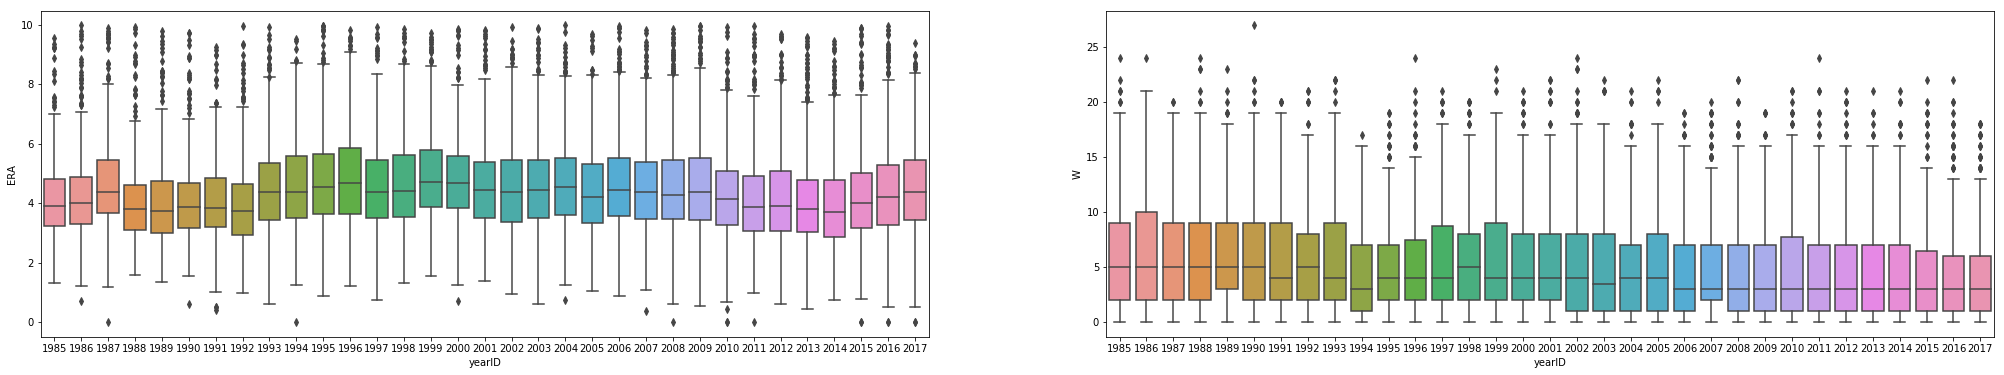

In [42]:
df = pitching[pitching.ERA < 10]
f, axes = plt.subplots(1,2, figsize=(35,6))
z = sns.boxplot(data=df, x='yearID', y='ERA', ax=axes[0])
b = sns.boxplot(data=df, x='yearID', y='W', ax=axes[1])

#### Correlation Between ERA and Wins
The hexagon joint-plot shows distribution, density and correlation in one graph.  ERA is normally distributed with a slightly long tail on the high side.  Wins are significantly left skewed.  The darker blue colors indicate density of data points.  The highest concentration of data points can be see for pitchers with less than five wins and an ERA between 3 and 6.  The Pearson's R score of -0.21 indicates a slight negative correlation between Wins and ERA.  This is to be expected.  The correlation would likely be more significant if the population contained only starting pitchers.  

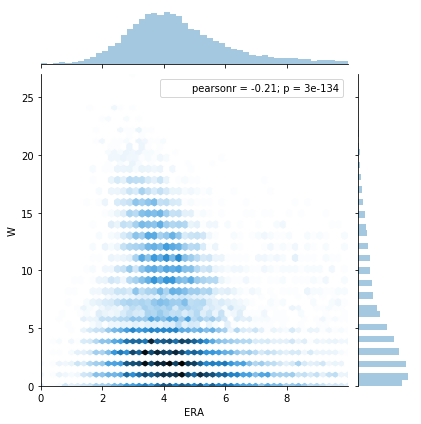

In [43]:
j = sns.jointplot(data=df, x ='ERA', y='W', kind='hex')

#### Data Exploration- Selected Variable

The grid-plot shows pairwise scatter plot of a select set of variables from the pitcher data set.  The variables are: ERA, Wins (W), Losses (L), Innings Pitched outs (IPOuts), Strikeouts (SO), Salary (AdjSalary2). To add an additional layer of analysis, the results are grouped by pitcher's throwing hand, to see if there is variability resulting from it.  

Look at the histograms, it is apparent that most of the data has skewed distributions, except for ERA, which has a somewhat normal distribution.  The non-normal distributions can be explained by the nature of the game of baseball.  Example, it is expected that losses (L) would be right skewed because pitchers that have many losses (L) are either demoted to minor leagues or cut by the team, making the distribution artificially right skewed.  

The pairwise scatter plots appear to follow normal understanding of the game of baseball. As an example, let’s look at ERA-Wins.  ERA for pitchers tend to be in the range of 2 to 6. As the ERA value decreases, the number of wins tends to increase.  On the very lower end of the ERA values, the decrease in wins may be due to the pitcher being a reliever/closer and not getting credited for the Wins.

There was some difference noticed between right-handed (Blue) and left-handed (green) pitchers but nothing substantial.  One thing noted is the salaries of left-handed pitchers tend to be lower than right-handed pitchers.  This may have something to do with the lower number of wins and losses attributed to left-handers.  This may be a side effect of Left-handed pitchers not usually considered as starters but more a specialty.  This assumption can be backed up by IPOuts which show left-handers tend to pitch less innings. (IPOuts is Innings pitched * 3 outs/inning)

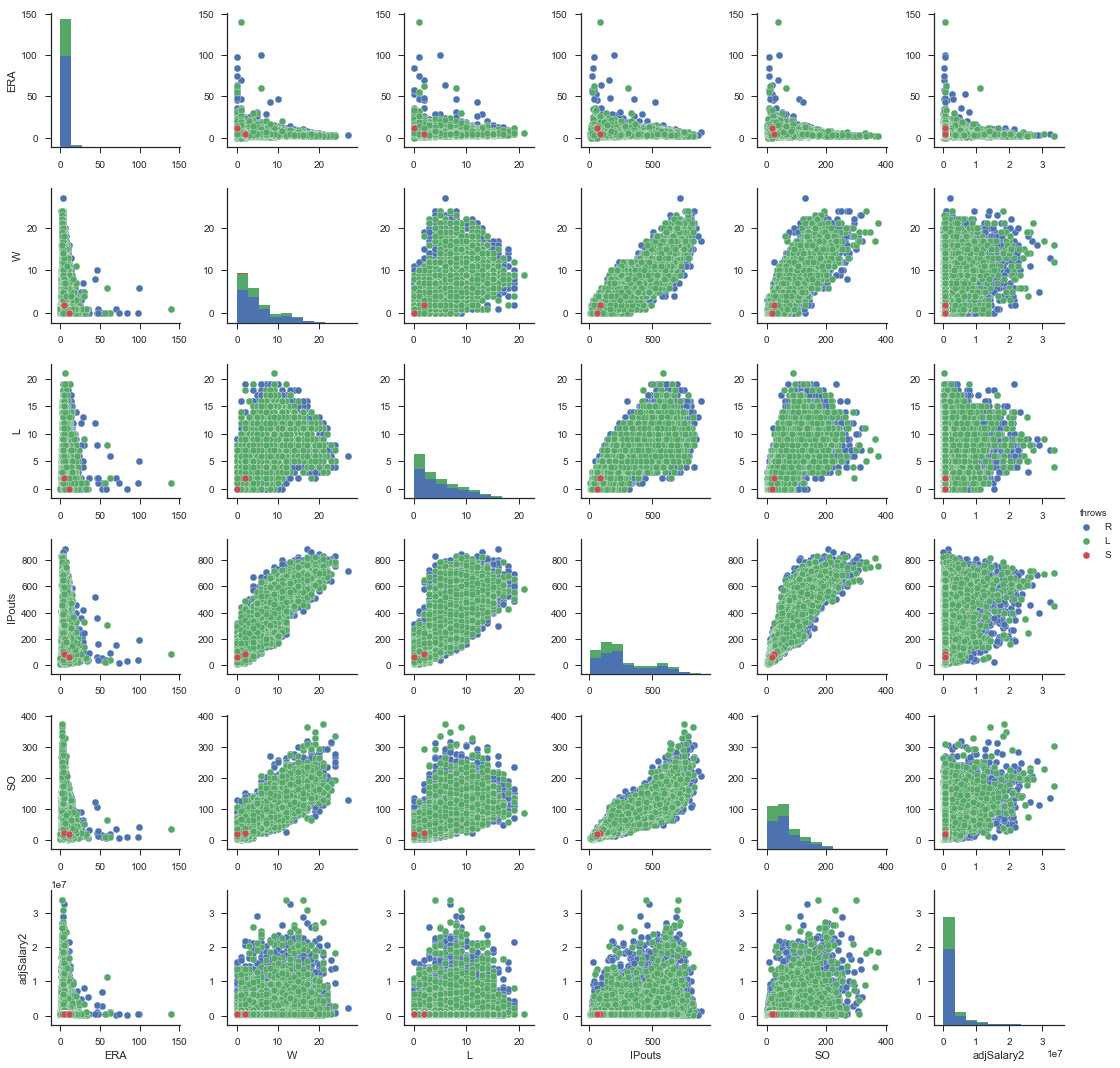

In [48]:
sns.set(style="ticks")
sns.pairplot(pitching[['ERA','W','L','IPouts','SO','adjSalary2','throws']],hue="throws")

#### Seaborn Clustermap
The Seaborn Clustermap shown below is a hierarchically clustered heatmap.  The cluster grid image utilizes the correlation matrix function of the temporary data frame generated from the pitching data to identify instances of correlation between attributes.  Structure of positively correlated attributes appear in this image as lighter colors.  Whereas negatively correlated attributes are shown in darker shades.  This provides some insight into how the data works as a unit.  It is interesting to note ERA is only moderately correlated with two attributes: opponent batting average and stint.  However, wins are highly and moderately correlated with most attributes in the data set.  

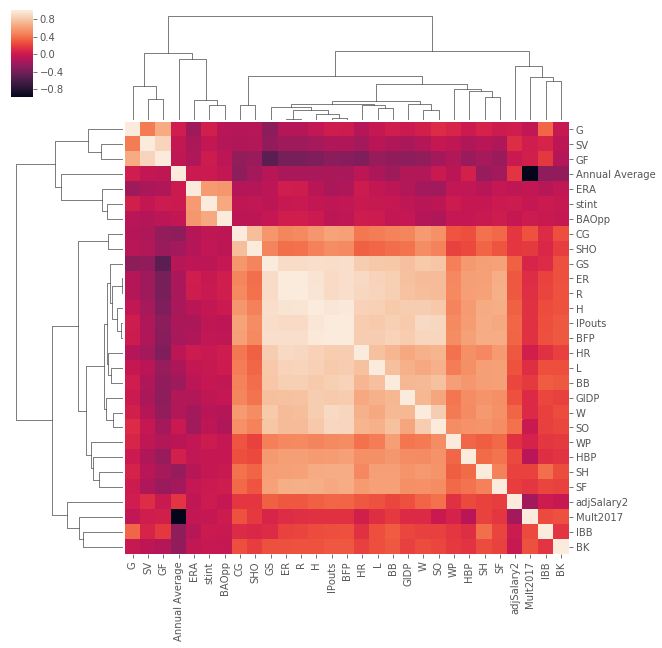

In [46]:
df = pitching.drop(['playerID', 'bats', 'throws', 'MinSalaries', 'adjMinSalaries', 'salary', 'adjSalary', 'yearID', 'weight', 'height'], axis=1)
sns.clustermap(df.corr())
plt.show()

---

## Modeling and Evaluation 1

In this Lab, we will investigate several different clustering algorithms and a variety of parameter combinations for each model.  In particular, Spectral Clustering, Hierarchical Agglomerative Clustering, HDBSCAN, and Gaussian Mixture Models models will be produced.  Scatter plots and evaluation metrics; such as, silhouette score are generated during this step, which will aid in the evaluation and comparison of models in the Modeling and Evaluation 2 section.

##### Visualizations
Pitching statistics, Wins and ERA will typically be utilized for all cluster graphics. 
##### Groupings
Two natural grouping for Pitchers are a) starting pitchers and b) relievers.  The pitching data set does not differentiate pitchers in this manner.  All pitchers are simply given a position of "P".  Pitchers who are relievers can be further sub-divided into middle relievers and closers.  The assumption entering this section is showing clustering results using Wins and ERA will aid in providing clusters where the sub-divisions of pitchers (starters, relievers) may become evident. 

In [44]:
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture
import hdbscan
from sklearn.manifold import spectral_embedding
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib as mpl
from PIL import Image
import itertools
from scipy import linalg
from sklearn.metrics import pairwise

##### Importing Pitching data set - UnScaled
Importing the unscaled Pitching data set created in the Data Understanding step will be utilized in this section.  We will use the .pkl format.

In [45]:
pitching = pd.read_pickle("./analysisdata/pitching.pkl")
pitchingSv = pitching

#Create list to Consolidate Results of Clustering Models
clustResults = []

### Data Preprocessing
The output of data understanding was not intended to solve the needs of every clustering model.  As such, some data filtering steps will take place is this section to allow for flexible modeling.
##### Data Filtering - ERA Outliers and Year ID
As shown below, the range of ERA is from 0 to 139.5.  Typically, pitchers with a ERA over 6 do not have long careers in the Major Leagues.  However, there are instances where pitchers who represent major investments by a team are allowed to pitch with a higher ERA while gaining experience.  For example, Corey Kluber's (2 time American League Cy Young winner (2014, 2017)) was 8.31 in his first season.

To reduce unnecessary noise in the clustering model, a generous rule of ERA less than 9 (one run per inning) will be implemented to restrict unnaturally high ERAs.  

The pitcher.pkl file has annual pitcher data dating back to 1985.  Comparing a pitcher from 2017 with a pitcher from 1985 could be interesting, but a more practical approach will be clustering pitchers with more recent performance statistics to improve comparisons to active players.  Therefore, pitching records greater than the year 2012 will be selected for cluster analysis.

In [46]:
print('\nPitching ERA - 1985-2017')
print(pitching.ERA.describe().round(2))
pitching = pitching[pitching.ERA < 9]
pitching = pitching[(pitching.yearID > 2012)]
#pitching = pitching[(pitching.yearID > 2012) & (pitching.yearID <= 2016)]
print('\nPitching ERA - 2012-2017 & ERA <9')
print(pitching.ERA.describe().round(2))


Pitching ERA - 1985-2017
count    14473.00
mean         5.03
std          3.68
min          0.00
25%          3.39
50%          4.31
75%          5.57
max        139.50
Name: ERA, dtype: float64

Pitching ERA - 2012-2017 & ERA <9
count    2466.00
mean        4.18
std         1.56
min         0.00
25%         3.11
50%         4.00
75%         5.02
max         8.96
Name: ERA, dtype: float64


##### Drop Unnecessary Columns and Scaled Data

The pitchingSC data frame is created in this step, to allow for manipulation of the data frame while retaining the base pitching data frame input into this cell.  It is envisioned that post-hoc cluster analysis will likely involve comparing salaries of pitchers in the same cluster.  So, we will eliminate salary attributes from the newly created pitchingSC data frame.  Categorical data like playerID will be removed as well.  PlayerID, along with salary information, have been saved in the pitchIDs data frame.  This data frame will allow for these variables to be joined back to the pitchingSC data frame if required.  Through model experimentation, height and weight were determined to not add value to the clustering models.  So, they will be dropped as well.  Finally, the pitchers throwing hand will be encoded using pandas get_dummies. 

Experimentation with pitching scaled data frames did not improve clustering results.  Clustering results using scaled data are not presented in this report.  All clustering models will utilized the unscaled pitching data.

In [47]:
#Save pitcher IDs for potential post clustering analysis
pitchIDs = pitching[['yearID', 'playerID', 'salary', 'adjSalary2']]
#print(pitchIDs)

#One Hot Encoding for throws
tmp_df = pd.get_dummies(pitching.throws,prefix='throws')
pitchingSC = pd.concat((pitching,tmp_df),axis=1) # add back into the dataframe

#Drop Throws after one-hot encoding
#Drop Attributes no longer needed (MinSalaries, adjMinSalaries, adjSalary, playerID, bats, stint
pitchingSC = pitchingSC.drop(['height', 'weight', 'salary', 'MinSalaries', 'adjMinSalaries', 'adjSalary', 'adjSalary2', 'playerID', 'bats', 'stint', 'throws'], axis=1)
colNamesPSC = pitchingSC.columns

#Scale pitchingSC
scaler = StandardScaler()
pitchingSCScaled = scaler.fit_transform(pitchingSC)
pitchingSCScaled = pd.DataFrame(pitchingSCScaled, columns=colNamesPSC)

##### Create Value Based Arrays from Pitching Data Frames
Some clustering algorithms require data to be in array form.  This section will create value based arrays of the pitchingSC data frame for input into those model.

In [48]:
#X = Unscaled values for Unscaled Data Frame
X = pitchingSC.iloc[:,0:30].values

#X2 for Scaled Data Frame
X2 = pitchingSCScaled.iloc[:,0:30].values

## Clustering

In the following sections, we will be training multiple clustering techniques, adjusting their parameters, to create an optimal clusters on the pitchingSC data frame.  The clustering techniques chosen for this analysis are:  *Spectral Clustering* , *Hierarchical Agglomerative Clustering* , *HDBSCAN* , and *GMM*.
We will take the optimal cluster from each clustering technique and compare them to each other, using the most appropriate comparison metric.


### Spectral Clustering - KNeighbors
#### Train and Adjust Parameters

This section will determine which combination of the number of clusters and K Nearest Neighbors produces the optimal Spectral Clustering result as measured by the Silhouette Coefficient.  This section will track the model with the best overall score as well as the best model with more two clusters. 

In [49]:
%%time

bestSil = 0
bestBigSil = 0

for nclust in range (2,6):
    for knn in range(5,26,5):
        Xknn = kneighbors_graph(X, knn)
        spcKNG = SpectralClustering(n_clusters=nclust, affinity = 'precomputed')
        labels = spcKNG.fit_predict(Xknn)
        silScore = metrics.silhouette_score(X, labels)
        print(nclust, "Clusters ;", knn, "KN Graph", "; Silhouette Coefficient: %0.4f" % silScore)
        if (silScore > bestSil):
            bestSil = silScore
            bestClust = nclust
            bestKnn = knn
        elif (nclust > 2):
            if (silScore > bestBigSil):
                bestBigSil = silScore
                bestBigClust = nclust
                bestBigKnn = knn

clustResults.append({'Model': 'Spectral Clustering', 'Silhouette_Score': bestSil, 'Clusters': bestClust, 'GT2_Silhouette_Score': bestBigSil, 'GT2_Clusters': bestBigClust, 'BIC': 0.0})

2 Clusters ; 5 KN Graph ; Silhouette Coefficient: 0.7087
2 Clusters ; 10 KN Graph ; Silhouette Coefficient: 0.7097
2 Clusters ; 15 KN Graph ; Silhouette Coefficient: 0.7095
2 Clusters ; 20 KN Graph ; Silhouette Coefficient: 0.7094
2 Clusters ; 25 KN Graph ; Silhouette Coefficient: 0.7089
3 Clusters ; 5 KN Graph ; Silhouette Coefficient: 0.4935
3 Clusters ; 10 KN Graph ; Silhouette Coefficient: 0.4936
3 Clusters ; 15 KN Graph ; Silhouette Coefficient: 0.4972
3 Clusters ; 20 KN Graph ; Silhouette Coefficient: 0.5010
3 Clusters ; 25 KN Graph ; Silhouette Coefficient: 0.5022
4 Clusters ; 5 KN Graph ; Silhouette Coefficient: 0.4710
4 Clusters ; 10 KN Graph ; Silhouette Coefficient: 0.4736
4 Clusters ; 15 KN Graph ; Silhouette Coefficient: 0.4781
4 Clusters ; 20 KN Graph ; Silhouette Coefficient: 0.4836
4 Clusters ; 25 KN Graph ; Silhouette Coefficient: 0.4813
5 Clusters ; 5 KN Graph ; Silhouette Coefficient: 0.4582
5 Clusters ; 10 KN Graph ; Silhouette Coefficient: 0.4617
5 Clusters ; 15 KN

#### Visualize Spectral Clustering Results

Below, we are visualizing the Spectral Clustering results using the optimal clustering parameters.

2 Clusters ; 10 KN Graph ; Silhouette Coefficient: 0.7097


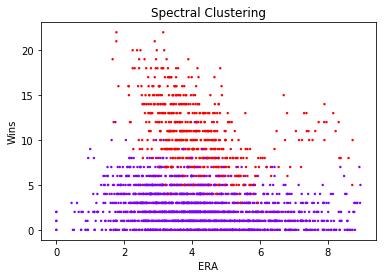

3 Clusters ; 25 KN Graph ; Silhouette Coefficient: 0.5022


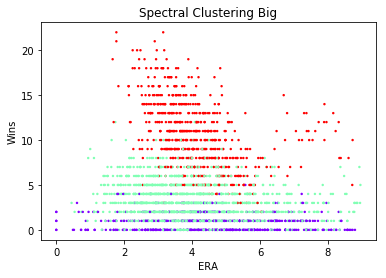

In [50]:
#print(spcKNG.affinity_matrix_)
#print(spcKNG.labels_)

#nclust = 2
#Best Spectral Cluster
Xknn = kneighbors_graph(X, bestKnn)

spcKNG = SpectralClustering(n_clusters=bestClust, affinity = 'precomputed')
labelsSC = spcKNG.fit_predict(Xknn)
#print(len(labels))

plt.scatter(X[:, 14], X[:, 0], c=labelsSC, cmap=plt.cm.rainbow, s=6, linewidths=0)
print(bestClust, "Clusters ;", bestKnn, "KN Graph", "; Silhouette Coefficient: %0.4f" % metrics.silhouette_score(X, labelsSC))
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title('Spectral Clustering')
plt.savefig('./plots/SC.png')
plt.show()

#Best Spectral Cluster with > 2 Clusters
Xknn = kneighbors_graph(X, bestBigKnn)

spcKNG = SpectralClustering(n_clusters=bestBigClust, affinity = 'precomputed')
labels = spcKNG.fit_predict(Xknn)
#print(len(labels))

plt.scatter(X[:, 14], X[:, 0], c=labels, cmap=plt.cm.rainbow, s=6, linewidths=0)
print(bestBigClust, "Clusters ;", bestBigKnn, "KN Graph", "; Silhouette Coefficient: %0.4f" % metrics.silhouette_score(X, labels))
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title('Spectral Clustering Big')
plt.savefig('./plots/SC2.png')
plt.show()

### Hierarchical Agglomerative Clustering
#### Train and Adjust Parameters
This section will determine which combination of linkage and number of clusters produces the optimal Hierarchical Agglomerative Clustering result as measured by the Silhouette Coefficient.  This section will track the model with the best overall score as well as the best model with more than two clusters.  

In [51]:
%%time 

bestSil = 0
bestBigSil = 0

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(2,6):
        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(pitchingSC)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering
        silScore = metrics.silhouette_score(pitchingSC, newfeature_fam)
        print(n_fam, "Clusters", "; Linkage:", link, "; Silhouette Coefficient: %0.4f" % silScore)
        if (silScore > bestSil):
            bestSil = silScore
            bestClust = n_fam
            bestLink = link
        elif (n_fam > 2):
            if (silScore > bestBigSil):
                bestBigSil = silScore
                bestBigClust = n_fam
                bestBigLink = link        
                #print(bestBigSil, bestBigClust, bestBigLink)
                
clustResults.append({'Model': 'Hierarchical Agglomerative Clustering', 'Silhouette_Score': bestSil, 'Clusters': bestClust, 'GT2_Silhouette_Score': bestBigSil, 'GT2_Clusters': bestBigClust, 'BIC': 0.0})

2 Clusters ; Linkage: ward ; Silhouette Coefficient: 0.6986
3 Clusters ; Linkage: ward ; Silhouette Coefficient: 0.6084
4 Clusters ; Linkage: ward ; Silhouette Coefficient: 0.5490
5 Clusters ; Linkage: ward ; Silhouette Coefficient: 0.5115
2 Clusters ; Linkage: complete ; Silhouette Coefficient: 0.6923
3 Clusters ; Linkage: complete ; Silhouette Coefficient: 0.6210
4 Clusters ; Linkage: complete ; Silhouette Coefficient: 0.4985
5 Clusters ; Linkage: complete ; Silhouette Coefficient: 0.4785
2 Clusters ; Linkage: average ; Silhouette Coefficient: 0.6701
3 Clusters ; Linkage: average ; Silhouette Coefficient: 0.6054
4 Clusters ; Linkage: average ; Silhouette Coefficient: 0.5147
5 Clusters ; Linkage: average ; Silhouette Coefficient: 0.5038
Wall time: 5.94 s


#### Visualize Hierarchical Agglomerative Clustering Results

Below, we are visualizing the Hierarchical Agglomerative Clustering results using the optimal clustering parameters.

2 Clusters ; Linkage: ward ; Silhouette Coefficient: 0.6986


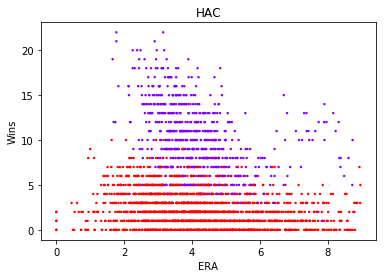

3 Clusters ; Linkage: complete ; Silhouette Coefficient: 0.6210


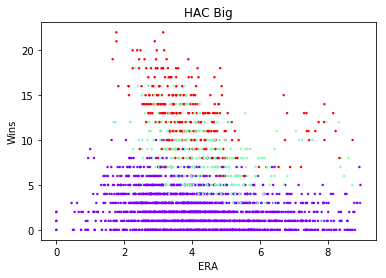

In [52]:
#Best HAC Model
cls_fam = AgglomerativeClustering(n_clusters=bestClust, linkage=bestLink)
cls_fam.fit(pitchingSC)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering
print(bestClust, "Clusters ;", "Linkage:", bestLink, "; Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, newfeature_fam))

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=newfeature_fam, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title('HAC')
plt.savefig('./plots/HAC.png')
plt.show()

#Best HAC Model with > 2 Clusters
cls_fam = AgglomerativeClustering(n_clusters=bestBigClust, linkage=bestBigLink)
cls_fam.fit(pitchingSC)
newfeature_famSV = cls_fam.labels_ # the labels from kmeans clustering
print(bestBigClust, "Clusters ;", "Linkage:", bestBigLink, "; Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, newfeature_famSV))

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=newfeature_famSV, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title('HAC Big')
plt.savefig('./plots/HAC2.png')
plt.show()

### HDBSCAN
#### Train and Adjust Parameters
HDBSCAN is a relatively new clustering algorithm created by the makers of DBSCAN.  The best HDBSCAN model will be produces by testing various combinations of minimum cluster size and minimal sample size.

This section will determine which combination of minimum cluster size and minimal sample size that produces the optimal HDBSCAN Clustering result as measured by the Silhouette Coefficient.  This section will track the model with the best overall score. 

In [53]:
%%time 

bestSil = 0

params = []
for mcs in range(10,60,10):
    for ms in range(1, 6, 1):
        cls_hdbs = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        cls_hdbs.fit(pitchingSC)
        labelsHdbs = cls_hdbs.labels_ # the labels from kmeans clustering
        silScore = metrics.silhouette_score(pitchingSC, labelsHdbs)
        print(mcs, "Min Cluster Size", ms, "Min Samples", "Silhouette Coefficient: %0.4f" % silScore)
        if (silScore > bestSil):
            bestSil = silScore
            bestMCS = mcs
            bestMS = ms

10 Min Cluster Size 1 Min Samples Silhouette Coefficient: -0.3040
10 Min Cluster Size 2 Min Samples Silhouette Coefficient: -0.3157
10 Min Cluster Size 3 Min Samples Silhouette Coefficient: -0.3071
10 Min Cluster Size 4 Min Samples Silhouette Coefficient: -0.2585
10 Min Cluster Size 5 Min Samples Silhouette Coefficient: -0.1835
20 Min Cluster Size 1 Min Samples Silhouette Coefficient: -0.2381
20 Min Cluster Size 2 Min Samples Silhouette Coefficient: 0.3078
20 Min Cluster Size 3 Min Samples Silhouette Coefficient: -0.1625
20 Min Cluster Size 4 Min Samples Silhouette Coefficient: -0.1672
20 Min Cluster Size 5 Min Samples Silhouette Coefficient: -0.1642
30 Min Cluster Size 1 Min Samples Silhouette Coefficient: -0.0713
30 Min Cluster Size 2 Min Samples Silhouette Coefficient: -0.1284
30 Min Cluster Size 3 Min Samples Silhouette Coefficient: -0.1701
30 Min Cluster Size 4 Min Samples Silhouette Coefficient: -0.1531
30 Min Cluster Size 5 Min Samples Silhouette Coefficient: -0.1445
40 Min Clus

#### Visualize HDBSCAN Results
Below, we are visualizing the HDBSCAN Clustering results using the optimal clustering parameters.

40 Min Cluster Size; 4 Min Samples; Silhouette Coefficient: 0.4395


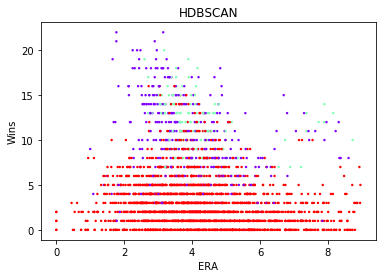

In [54]:
#Best HAC Model
cls_hdbs = hdbscan.HDBSCAN(min_cluster_size=bestMCS, min_samples=bestMS)
cls_hdbs.fit(pitchingSC)
labelsHdbs = cls_hdbs.labels_ 
print(bestMCS, "Min Cluster Size;", bestMS, "Min Samples;", "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, labelsHdbs))

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=labelsHdbs, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title('HDBSCAN')
plt.savefig('./plots/Hdbscan.png')
plt.show()

clustCount = np.unique(labelsHdbs)
clustResults.append({'Model': 'HDBSCAN', 'Silhouette_Score': bestSil, 'Clusters': len(clustCount), 'GT2_Silhouette_Score': 0, 'GT2_Clusters': 0, 'BIC': 0.0})

### Gaussian Mixture Models
This section will determine which combination of number of components, covariance type and paramter type produces the optimal GMM Clustering result as measured by the BIC and/or Silhouette Coefficient.
Maximum iterations and random state will be fixed at 200 and 42, respectively.

In [55]:
%%time
# this code has been manipulated from the source available on sklearn's website documentation
bestSil = 0
lowest_bic = np.infty
bic = []
n_components_range = range(8,18)
cv_types = ['spherical','tied', 'diag', 'full']
in_parm_types = ['random','kmeans']
for in_parm_type in in_parm_types:
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type, init_params=in_parm_type, max_iter=200, random_state=42)
            gmm.fit(pitchingSC)
            gmmLabels = gmm.predict(pitchingSC)
            silScore = metrics.silhouette_score(pitchingSC, gmmLabels)
            bic.append(gmm.bic(pitchingSC))
            print(n_components, "Components;", cv_type, "Covariance Type;", in_parm_type, "Params;", 'BIC %.2f' % bic[-1], '; Sil. Score %.4f' % silScore)
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                lowest_bic_silScore = silScore
                best_gmm = gmm
            if (silScore > bestSil):
                bestSil = silScore
                bestSil_bic = gmm.bic(pitchingSC)

#clustResults.append({'Model': 'Gaussian Mixture Models', 'Silhouette_Score': bestSil, 'GT2_Silhouette_Score': 0, 'BIC': lowest_bic})

8 Components; spherical Covariance Type; random Params; BIC 525150.54 ; Sil. Score 0.3896
9 Components; spherical Covariance Type; random Params; BIC 519196.81 ; Sil. Score 0.3734
10 Components; spherical Covariance Type; random Params; BIC 511988.91 ; Sil. Score 0.3423
11 Components; spherical Covariance Type; random Params; BIC 505543.90 ; Sil. Score 0.3362
12 Components; spherical Covariance Type; random Params; BIC 505753.34 ; Sil. Score 0.3362
13 Components; spherical Covariance Type; random Params; BIC 498312.41 ; Sil. Score 0.3244
14 Components; spherical Covariance Type; random Params; BIC 494334.32 ; Sil. Score 0.3188
15 Components; spherical Covariance Type; random Params; BIC 490739.23 ; Sil. Score 0.3008
16 Components; spherical Covariance Type; random Params; BIC 490077.17 ; Sil. Score 0.2944
17 Components; spherical Covariance Type; random Params; BIC 484675.85 ; Sil. Score 0.2837
8 Components; tied Covariance Type; random Params; BIC 265877.73 ; Sil. Score -0.1547
9 Comp

In [56]:
print('The optimal model parameters, based on lowest BIC value:')
print(best_gmm)
#print(bic)
print('\nLowest BIC: %.2f' % lowest_bic,'; Corresponding Silhouette Score: %.4f' %lowest_bic_silScore,'\nBest Silhouette Score: %.4f' % bestSil,'; Corresponding BIC Score: %.2f' % bestSil_bic)

The optimal model parameters, based on lowest BIC value:
GaussianMixture(covariance_type='full', init_params='random', max_iter=200,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

Lowest BIC: 134968.43 ; Corresponding Silhouette Score: -0.0758 
Best Silhouette Score: 0.3896 ; Corresponding BIC Score: 525150.54


NOTE:  The Lowest BIC Score and Best Silhouette Scores do not occur with the same GMM model parameters.
  
  

#### GMM BIC Bar Chart
The bar chart displayed below provides a graphical method to view the BIC scores of the various Guassian Mixture Model combinations created above.  An asterisk above the bar with the lowest BIC score denotes the best GMM model.

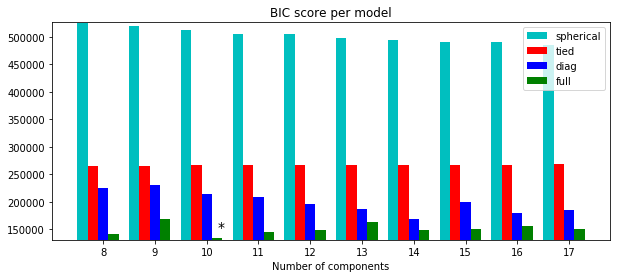

In [57]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['c', 'r', 'b', 'g', 'k', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

#### Display GMM Cluster Graph
Below, we are visualizing the GMM Clustering results using the optimal clustering parameters, according to min BIC score.

GaussianMixture(covariance_type='full', init_params='random', max_iter=200,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


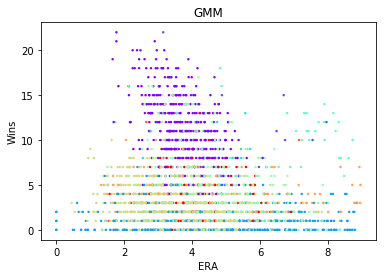

In [58]:
#Best GMM Model
gmm = mixture.GaussianMixture(covariance_type='full', init_params='random', max_iter=200,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
gmm.fit(pitchingSC)
gmmLabels = gmm.predict(pitchingSC)

clustCount = np.unique(gmmLabels)

print(best_gmm)

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=gmmLabels, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title("GMM")
plt.savefig('./plots/Gmm.png')
plt.show()

clustResults.append({'Model': 'Gaussian Mixture Model', 'Silhouette_Score': bestSil, 'Clusters': len(clustCount), 'GT2_Silhouette_Score': 0, 'GT2_Clusters': 0, 'BIC': lowest_bic})

---
## Modeling and Evaluation 2
The models generated in "Modeling and Evaluation 1" will be compared using visual examination and common metrics, to determine the best model(s) to use for analyzing pitcher clusters.  The optimal parameters and scoring metrics from each of the clustering techniques developed in "Modeling and Evaluation 1" is stored in a list named "clustResults".
This section begins by transforming the list into a data frame for display purposes.

The following guideline for evaluating silhouette scores is as follows score >= 0.70 is a strong model, 0.50 - 0.69 is an usable model, 0.26 - 0.49 is a weak model and < 0.25 is generally unusable.  This guideline can be found at https://www.stat.berkeley.edu/~spector/s133/Clus.html.

The table shows the best overall model is the Spectral Clustering model with which happened to have two clusters with a silhouette score of 0.7097.  However, the Hierarchical Agglomerative Clustering model produced good results for both a two cluster model (0.6986) and a three cluster model (0.6210).

The column titled "GT2_Silhouette_Score" shows the best silhouette score achieved by a model with more than two clusters.  This column is utilized for those models where the number of clusters was specified or varied expressly via code.  The three cluster Hierarchical Agglomerative Clustering model may prove useful as the third cluster may provide an extra level of granularity which may be useful in evaluating pitchers.  
#### Metric Table

In [59]:
#Convert cluster results list to data frame.
dfClustResults = pd.DataFrame(clustResults)
dfClustResults = dfClustResults[['Model', 'Silhouette_Score', 'Clusters', 'GT2_Silhouette_Score', 'GT2_Clusters', 'BIC']]
dfClustResults.round(4)

Model  Silhouette_Score  Clusters  \
0                    Spectral Clustering            0.7097         2   
1  Hierarchical Agglomerative Clustering            0.6986         2   
2                                HDBSCAN            0.4395         3   
3                 Gaussian Mixture Model            0.3896        10   

   GT2_Silhouette_Score  GT2_Clusters          BIC  
0                0.5022             3       0.0000  
1                0.6210             3       0.0000  
2                0.0000             0       0.0000  
3                0.0000             0  134968.4338

#### Visual Model Comparison

The Wins versus ERA scatter plots for all models, grouped by clusters are displayed below.  

Examination of the top performing Spectral Clustering plot titled "Spectral Clustering" shows two defined clusters.  Well defined globular clusters do not appear to exist for pitchers.  However, Spectral Clustering did create clusters with minimal overlap.

The Hierarchical Agglomerative Clustering (HAC) model with two clusters produces results very similar to the spectral clustering model.  The "HAC Big" plot show a third cluster.  Separation between the red and green clusters appears to be an issue.  However, the silhouette score indicates this is a strong model.  As stated previously, the addition of a third cluster could provide interesting detail and a layer of definition between starters, middle relievers and closers.  

Visual analysis of the HDBSCAN model with 3 clusters and Gaussian Mixture Model (GMM) with 10 clusters do not appear to have well defined clusters.  This is backed up by the low silhouette scores 0.4395 and 0.3896 respectively. According to guidelines, these models are weak.  
The HDBSCAN model cluster sizes are disproportional, with the majority of the observations clustered in a single cluster (red), while the remaining observations (cyan, magenta) are clustered at the perimeter (extremes) of the observations.  
The GMM model clusters do appear to be relatively proportional in size.  Some of the clusters are not well defined.  A good example is the (red) cluster, which is scattered throughout and within neighboring clusters. 

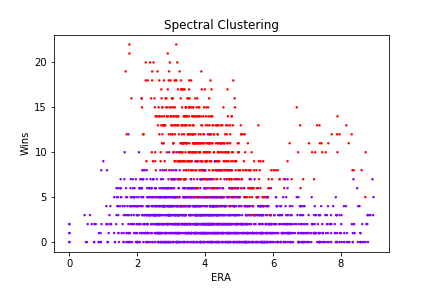

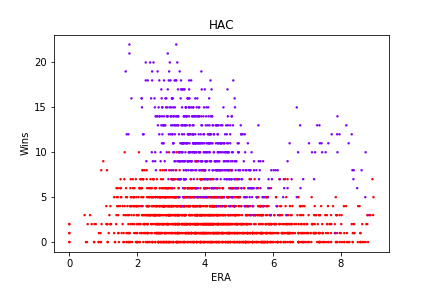

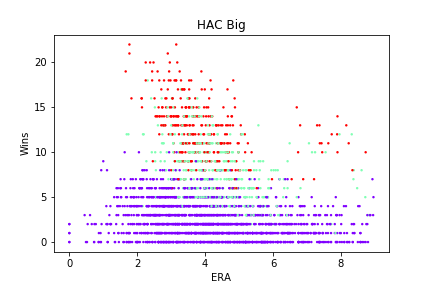

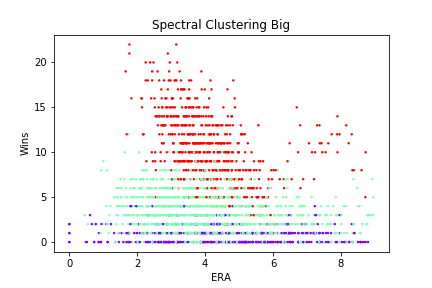

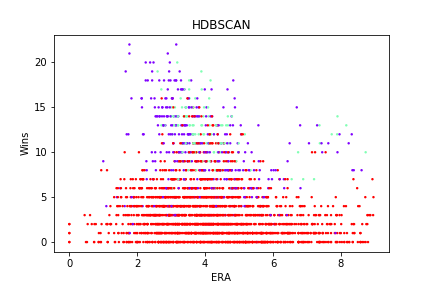

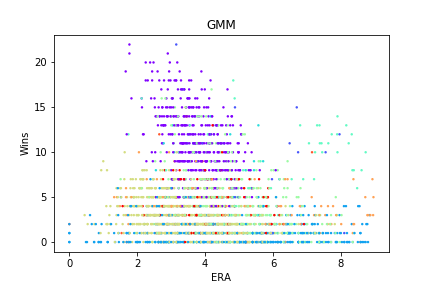

In [60]:
plots = ["./plots/SC.png", "./plots/HAC.png", "./plots/HAC2.png", "./plots/SC2.png", "./plots/Hdbscan.png",  "./plots/Gmm.png"]

for p in plots:
    display(Image.open(p))

#### Models to Examine in Additional Detail

The top performing Spectral Clustering Model and, for reasons listed above, the HAC model with three clusters will be examined in further detail.

---
## Modeling and Evaluation 3
This section will focus on visualizing the results of the two cluster Spectral Cluster and three cluster Hierarchical Agglomerative Clustering (HAC) models described in the prior two sections.  Cluster scatter plots by Wins and ERA have been generated, presented and analyzed in "Modeling and Evaluation 2".  These will not be regenerated in this section.  A dendrogram would be a nice way to visualize the results of HAC.  However, the subset data size is too large to generate a readable dendrogram.  Instead, the focus of this section will be on producing new methods to examine clustering results.

#### Similarity Matrix Plotting Function

In [61]:
### Credit to:  https://github.com/eclarson/DataMiningNotebooks/blob/master/10.%20Clustering%20Validity.ipynb

def plotSimMatrix(lab, title, data):
    y=lab
    idx_sorted = np.argsort(y,kind="quicksort")  # need to get the ordering of Y
    data_sorted = data[idx_sorted]  # sort the dataset by class
    R = pairwise.euclidean_distances(data_sorted)  # calculate the similarity

    #transform distance to similarity
    min_r = np.min(R)
    max_r = np.max(R)
    R = 1-(R-min_r)/(max_r-min_r)

    plt.figure(figsize=(15,10))
    plt.pcolormesh(R)
    plt.colorbar()

    # plot class boundaries
    bounds = np.cumsum([np.sum(y==val) for val in np.unique(y)])
    for b in bounds:
        plt.plot([b,b],[0, len(y)],'k',linewidth=1)
        plt.plot([0, len(y)],[b,b],'k',linewidth=1)

    plt.title(title)
    plt.show()

#### Similarity Plot Analysis

The similarity plots are color coded to show how similar one observation is to all other observations in the data set.  In order from most similar to least similar, the color scale for the charts shown below goes from yellow to green to blue to purple.  With approximately 2400 pitcher records remaining in the data set, it is not practical to use the similarity matrix for pitcher to pitcher analysis.  However, clusters of similarity and the general degree of similarity can be observed by viewing the plots. 

Visual examination of the "Spectral Clustering - 2 Clusters" plot clearly show the two clusters identified by the model.  These are a greenish-yellow color in the 0.8 range.  The boxes showing dissimilar observations appear to have a color score somewhere between 0.4 and 0.6.  The clusters are fairly well defined in the plot.  The "HAC - 3 Clusters" plot identifies the three well defined clusters identified by the Hierarchical Agglomerative Clustering algorithm.  In general, the similar clusters in the HAC  plot appear to be more yellow compared to the Spectral Clustering plot.  This would suggest the clusters are more cohesive.  However, a greater portion of the HAC graph falls into the green to purple color spectrum when compared to the Spectral Clustering plot.  This seems to coincide with the Silhouette score of 0.7097 for Spectral Clustering and 0.6210 for the three cluster HAC model.  

In the end, both models could be useful for evaluating pitchers.  The Spectral clustering model would be a bit more inclusive in terms of the number of highly similar observations while the HAC model would provide more cohesive clusters with higher similarity.  With the subject matter being pitchers, a tradeoff between cluster inclusion for higher cohesion may be suitable.

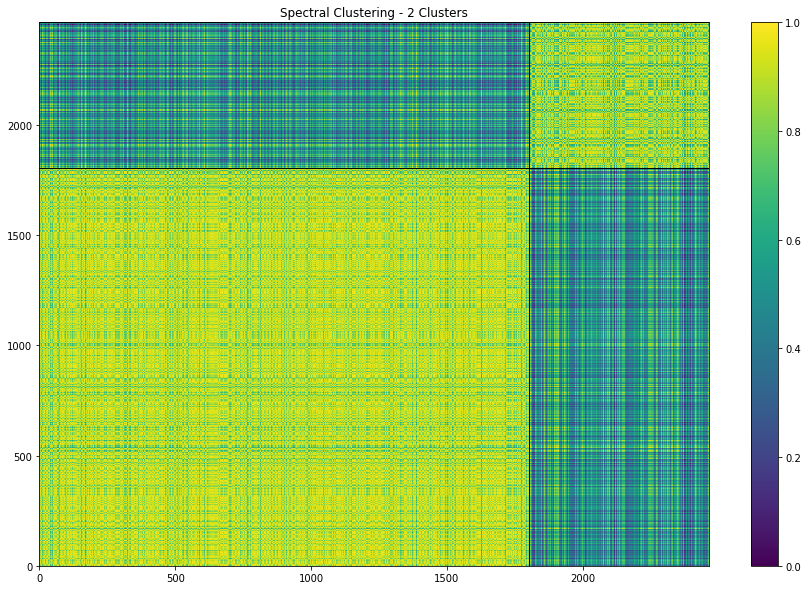

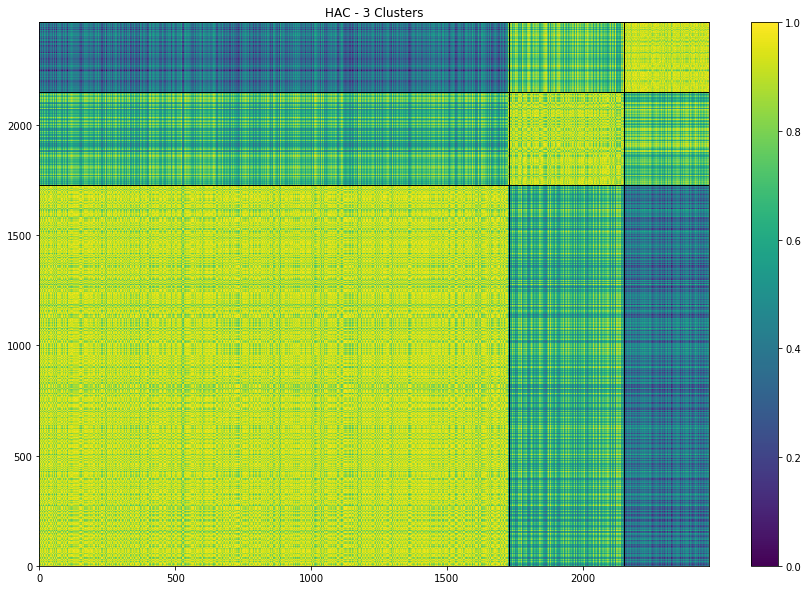

Wall time: 12.6 s


In [62]:
%%time
#Spectral Clustering Similarity Matrix
plotSimMatrix(labelsSC, "Spectral Clustering - 2 Clusters", X)

#HAC Similariy Matrix
plotSimMatrix(newfeature_famSV, "HAC - 3 Clusters", X)

#GMM Similarity Matrix
#plotSimMatrix(gmmLabels, "GMM", X)

---
## Modeling and Evaluation 4

#### How can the clusters be used?
The use case of applying pitcher clusters to make personnel decisions will be examined.  Spectral Clustering and Hierarchical Agglomerative Clustering results will be used to examine pitchers similar to two past Cy Young Award winners:  Max Scherzer and Rick Porcello.  

- Max Scherzer 2016, 2017 NL Cy Young Winner (scherma01)
- Rick Porcello 2016 AL Cy Young Winner (porceri01)

#### Prepare New Data Frame for Analysis

Now that clustering is complete, key information to allow the identification of individual pitchers and their clusters for analysis must be merged back with the data used for clustering.  We begin by creating data frames from the cluster labels produced by HAC-3 and Spectral Clustering-2 Cluster (SC2) models.  These two label data frames are concatenated into a single data frame.  The pitchingSC data frame, which was the basis of data input into the clustering models, is concatenated with a data frame containing player demographics and salary information, creating a new data frame named pitchingClust.  Finally the cluster labels are merged into pitchingClust.  The end result is a data frame which enables pitcher level identification by Hierarchical Agglomerative and Spectral clusters.  The displayed output from this section is a count of pitcher records per cluster.

In [63]:
try:
    del pitchingClust
    #del df
except:
    pass

#Create Data Frame from best > 2 Cluster HAC Model Labels
hac3LabelsDf = pd.DataFrame(newfeature_famSV)
hac3LabelsDf.rename(index=str, columns={0: 'HAC3_Label'}, inplace=True)

#Get Counts for each HAC
df = hac3LabelsDf
df['count1'] = 1
print(df.groupby('HAC3_Label').sum())

#Create Data Frame from best Spectral Clustering Labels
sc2LabelsDf = pd.DataFrame(labelsSC)
sc2LabelsDf.rename(index=str, columns={0: 'SC2_Label'}, inplace=True)

#Get Counts for each Spectral cluster
df = sc2LabelsDf
df['count2'] = 1
print('\n',df.groupby('SC2_Label').sum())

#Combine the two label data frames
labelsDf = pd.concat([hac3LabelsDf, sc2LabelsDf], axis=1)
labelsDf.reset_index(inplace=True, drop=True)

#Concatenate the two dataframes to bring attributes such as playerID and salary back into the attributes used for clustering
pitchingClust = pd.concat([pitchingSC, pitchIDs], axis = 1)
pitchingClust.reset_index(inplace=True)
#print(pitchingClust)

#Add labels to pitchingClust
pitchingClust = pd.concat([pitchingClust, labelsDf], axis = 1, join='inner')
#pitchingClust

            count1
HAC3_Label        
0             1728
1              423
2              315

            count2
SC2_Label        
0            1803
1             663


##### Cluster Observation - Quantities

This observation is not scientific but it is intriguing that HAC3 and SC2 models have similar splits in number of observation in clusters (large cluster - 1728/1803). It looks like both models identified the similar clusters, while the HAC3 model split the smaller SC2 cluster into 2 clusters.  

##### Cy Young Winner - Identifying
The data rows for Cy Young Award winners, Max Scherzer and Rick Porcello are displayed below.

In [64]:
#Find 2016 Cy Young Winners in pitchingClust
#Max Scherzer 2016 NL Cy Young Winner (scherma01)
#Rick Porcello 2016 NL Cy Young Winner (porceri01)
#Corey Kluber, 2017 AL Cy Young Winner (klubeco01)

cyYoung = pitchingClust.loc[(pitchingClust['playerID'] == 'scherma01') | (pitchingClust['playerID'] == 'porceri01')]
cyYoung

index   W   L   G  GS  CG  SHO  SV  IPouts    H   ...    throws_R  \
346   16008  13   8  32  29   1    0   0     531  185   ...           1   
407   16086  21   3  32  32   0    0   0     643  152   ...           1   
819   16690  15  13  32  31   3    3   0     614  211   ...           1   
865   16765  18   5  33  33   1    1   0     661  196   ...           1   
1314  17414   9  15  28  28   0    0   0     516  196   ...           1   
1373  17498  14  12  33  33   4    3   0     686  176   ...           1   
1810  18152  22   4  33  33   3    0   0     669  193   ...           1   
1866  18228  20   7  34  34   1    0   0     685  165   ...           1   
2314  18897  11  17  33  33   2    0   0     610  236   ...           1   
2369  18974  16   6  31  31   2    0   0     602  126   ...           1   

      throws_S  yearID   playerID      salary    adjSalary2  HAC3_Label  \
346          0    2013  porceri01   5100000.0  5.365200e+06           2   
407          0    2013  scherma01   6725000.0  7.074700e+06           2   
819          0    2014  porceri01   8500000.0  8.797500e+06           2   
865          0    2014  scherma01  15525000.0  1.606837e+07           2   
1314         0    2015  porceri01  12500000.0  1.292500e+07           2   
1373         0    2015  scherma01  17142000.0  1.772483e+07           2   
1810         0    2016  porceri01  20125000.0  2.054762e+07           2   
1866         0    2016  scherma01  22142857.0  2.260786e+07           2   
2314         0    2017  porceri01         0.0  5.350000e+05           2   
2369         0    2017  scherma01         0.0  5.350000e+05           2   

      count1  SC2_Label  count2  
346        1          1       1  
407        1          1       1  
819        1          1       1  
865        1          1       1  
1314       1          1       1  
1373       1          1       1  
1810       1          1       1  
1866       1          1       1  
2314       1          1       1  
2369       1          1       1  

[10 rows x 38 columns]

#### Spectral Clustering - Pitchers Similar to Porcello and Scherzer

The spectral clustering affinity matrix will be utilized to show the pitchers most similar to Rick Porcello and Matt Scherzer.  

Examination of pitchers identified as be most similar to Rick Porcello has some interesting results.  As one of the game's top pitchers, Rick Porcello is similar to pitchers such as Justin Verlander and Adam Wainright on a year by year basis.  This shouldn't be a surprise.  However, there is a selection of lesser known veterans and young pitchers who show high affinity to Rick Porcello.  Statistically, Clayton Richards (richacl01) is a fairly average pitcher who has played for several teams over his eleven year career.  However, the similarity / high affinity to Rick Porcello could mean Richards is an attractive option for a team looking for an additional starting pitcher for a playoff run or for a short contract.  With a 2018 salary of \$3 Million, Richards is also a good value.  Two potential younger pitchers with a high affinity to Rick Porcello are Marcus Stroman (stromma01) and Collin McHugh (mchugco01).  Both are young pitchers with good statistics showing year to year improvements.  They could both be targets for a team looking to acquire a top three starting pitcher position for any team.  With 2018 salaries of \$5 Million for McHugh and \$6.5 Million for Stroman, they are not exactly cheap, but an argument could be made they have the talent to command eight figure salaries.  

Matt Scherzer is arguably the best pitcher in Major League Baseball.  He has won the NL Cy Young award for two years in a row.  As with Rick Porcello, some of the games best pitchers have a high affinity to Scherzer.  Interestingly, more potential "diamonds in the rough" can be found in the list of pitchers similar to Matt Scherzer.  Specifically, Luis Severino (severlu01), a young pitcher with amazing talent.  He is far from an unknown as he plays for the New York Yankees.  However, his 2018 salary of \$604,975 is not commensurate with his value.  Severino should be a acquisition target for any team looking to add a top line starter.  The similarity to Scherzer should encourage teams to extend an eight figure salary with a reasonable degree of confidence.  Noah Snydergaard (snydeno01) and Jose Fernandez (fernajo01) also show an affinity to Scherzer.  These are two young pitchers as well.  With both making sub \$3 Million salaries, they are attractive options to upgrade any team's pitching staff.  Again, the similarity to Scherzer should provide some level of confidence in extending a long term high value contract to them.

In [65]:
try:
    del df
except:
    pass

##Find Similar Pitchers from Spectral Cluster Affinity Matrix
#Spectral Clustering Affinity matrix is a scipy.sparse.csr.csr_matrix
#print(pd.DataFrame((spcKNG.affinity_matrix_).todense()))
df = pd.DataFrame((spcKNG.affinity_matrix_).todense())
#print(df)

#Similar to 2016 Porcello
porcello = df.iloc[[2314]]
porcello = porcello.loc[:, (porcello != 0).any(axis=0)]
print("Pitchers Similar to Rick Porcello")
pitchingClust.iloc[porcello.columns, 27:34].head(10)

Pitchers Similar to Rick Porcello


throws_L  throws_R  throws_S  yearID   playerID      salary    adjSalary2
47          1         0         0    2013  buehrma01  12000000.0  1.262400e+07
141         0         1         0    2013  fistedo01   4000000.0  4.208000e+06
198         1         0         0    2013  hollade01   3400000.0  3.576800e+06
245         1         0         0    2013  lestejo01  11625000.0  1.222950e+07
393         1         0         0    2013  sabatcc01  24285714.0  2.554857e+07
397         0         1         0    2013  samarje01   2640000.0  2.777280e+06
428         1         0         0    2013  stulter01    507600.0  5.339952e+05
572         0         1         0    2014  colonba01   9000000.0  9.315000e+06
608         0         1         0    2014  eovalna01    517000.0  5.350950e+05
665         0         1         0    2014  haranaa01   1000000.0  1.035000e+06

In [66]:
#Similar to Scherzer
scherzer = df.iloc[[2369]]
scherzer = scherzer.loc[:, (scherzer != 0).any(axis=0)]
print("")
print("Pitchers Similar to Matt Scherzer")
pitchingClust.iloc[scherzer.columns, 27:34].head(10)


Pitchers Similar to Matt Scherzer


throws_L  throws_R  throws_S  yearID   playerID      salary  \
48           1         0         0    2013  bumgama01    916667.0   
50           0         1         0    2013  burneaj01  16500000.0   
102          0         1         0    2013  darviyu01   9500000.0   
193          0         1         0    2013  hernafe02  20557143.0   
274          0         1         0    2013  masteju01   5687500.0   
407          0         1         0    2013  scherma01   6725000.0   
705          1         0         0    2014  kershcl01   4000000.0   
851          0         1         0    2014   rossty01   1980000.0   
1022         0         1         0    2015  carraca01   2337500.0   
1054         0         1         0    2015  degroja01    556875.0   

        adjSalary2  
48    9.643337e+05  
50    1.735800e+07  
102   9.994000e+06  
193   2.162611e+07  
274   5.983250e+06  
407   7.074700e+06  
705   4.140000e+06  
851   2.049300e+06  
1022  2.416975e+06  
1054  5.758088e+05

#### Hierarchical Agglomerative Clustering - Pitchers Similar to Porcello and Scherzer
The three cluster HAC results will be used to identify pitchers similar to Rick Porcello and Matt Scherzer as well.  The approach will be a bit different when compared to Spectral Clustering as a dendrogram will be utilized as the basis for identifying pitchers clustered with Porcello and Scherzer.

Porcello and Scherzer are both in the same cluster computed by the HAC model created in Modeling and Evaluation 1.  A subset of the pitchingClust data frame will be created with pitchers in their cluster. 

In [67]:
#Find Similar Pitchers from HAC Cluster
hacClust = pitchingClust[(pitchingClust.HAC3_Label == 2)]

#Prep hacClust for Agglomerative Clustering
#Save hacClust columns
hacClustSV = hacClust[['playerID', 'salary', 'adjSalary2']]

#Drop columns with no clustering value
hacClust = hacClust.drop(['playerID', 'salary', 'adjSalary2', 'HAC3_Label', 'count', 'SC2_Label', 'count2'], axis=1)

There are 315 pitchers in HAC3 cluster 2.  Comparing 313 other pitchers to Porcello and Scherzer is a daunting task.  So, this cluster will be reclustered using Hierarchical Agglomerative Clustering to create a smaller cluster of pitchers similar to Porcello and Scherzer.  

In [68]:
#Recluster hacClust to find more granular similarities
#Find optimal parms for recluster

bestSil = 0
bestBigSil = 0

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(2,6):
        # append on the clustering
        hac_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        hac_fam.fit(hacClust)
        hacLabels = hac_fam.labels_ 
        silScore = metrics.silhouette_score(hacClust, hacLabels)
        #print(n_fam, "Clusters", "Linkage:", link, "Silhouette Coefficient: %0.4f" % silScore)
        if (silScore > bestSil):
            bestSil = silScore
            bestClust = n_fam
            bestLink = link

hac_fam = AgglomerativeClustering(n_clusters=bestClust, linkage=bestLink)
hac_fam.fit(hacClust)
hacLabels = hac_fam.labels_ # the labels from kmeans clustering
print(bestClust, "Clusters", "Linkage:", bestLink, "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(hacClust, hacLabels))

#Reassemble the hacClust data frame
hacClust = pd.concat([hacClust, hacClustSV], axis = 1)
hacClust.reset_index(inplace=True, drop=True)
#print(hacClust)

2 Clusters Linkage: complete Silhouette Coefficient: 0.5996


Below, we display the pitcher records for Scherzer and Porcello in the new data frame.

In [69]:
#cyYoung2 = hacClust.loc[(hacClust['playerID'] == 'scherma01') | (hacClust['playerID'] == 'porceri01')]
#cyYoung2
hacClust.loc[(hacClust['playerID'] == 'scherma01') | (hacClust['playerID'] == 'porceri01')]

index   W   L   G  GS  CG  SHO  SV  IPouts    H      ...       GIDP  \
50   16008  13   8  32  29   1    0   0     531  185      ...       20.0   
60   16086  21   3  32  32   0    0   0     643  152      ...       10.0   
120  16690  15  13  32  31   3    3   0     614  211      ...       30.0   
127  16765  18   5  33  33   1    1   0     661  196      ...       15.0   
194  17414   9  15  28  28   0    0   0     516  196      ...       21.0   
204  17498  14  12  33  33   4    3   0     686  176      ...        5.0   
249  18152  22   4  33  33   3    0   0     669  193      ...       16.0   
259  18228  20   7  34  34   1    0   0     685  165      ...        6.0   
300  18897  11  17  33  33   2    0   0     610  236      ...       18.0   
307  18974  16   6  31  31   2    0   0     602  126      ...       13.0   

     yearID  throws_L  throws_R  throws_S  yearID  count1   playerID  \
50     2013         0         1         0    2013       1  porceri01   
60     2013         0         1         0    2013       1  scherma01   
120    2014         0         1         0    2014       1  porceri01   
127    2014         0         1         0    2014       1  scherma01   
194    2015         0         1         0    2015       1  porceri01   
204    2015         0         1         0    2015       1  scherma01   
249    2016         0         1         0    2016       1  porceri01   
259    2016         0         1         0    2016       1  scherma01   
300    2017         0         1         0    2017       1  porceri01   
307    2017         0         1         0    2017       1  scherma01   

         salary    adjSalary2  
50    5100000.0  5.365200e+06  
60    6725000.0  7.074700e+06  
120   8500000.0  8.797500e+06  
127  15525000.0  1.606837e+07  
194  12500000.0  1.292500e+07  
204  17142000.0  1.772483e+07  
249  20125000.0  2.054762e+07  
259  22142857.0  2.260786e+07  
300         0.0  5.350000e+05  
307         0.0  5.350000e+05  

[10 rows x 35 columns]

##### Create Dendrogram
The code commented out below was used to generate the dendrogram images shown below.  For brevity and document readability, these figures were saved to disk as images and redisplayed.  The "Full Recluster Dendrogram" shows the HAC recluster in total.  As can be seen below, a dendrogram with over 300 leaf values can be hard to consume.  So, a zoom in of the pitchers similar to Porcello and Scherzer at branch level 5 is shown as well.  In this figure, Porcello is observation 300.  Scherzer is observation 307.  

Full Recluster Dendrogram


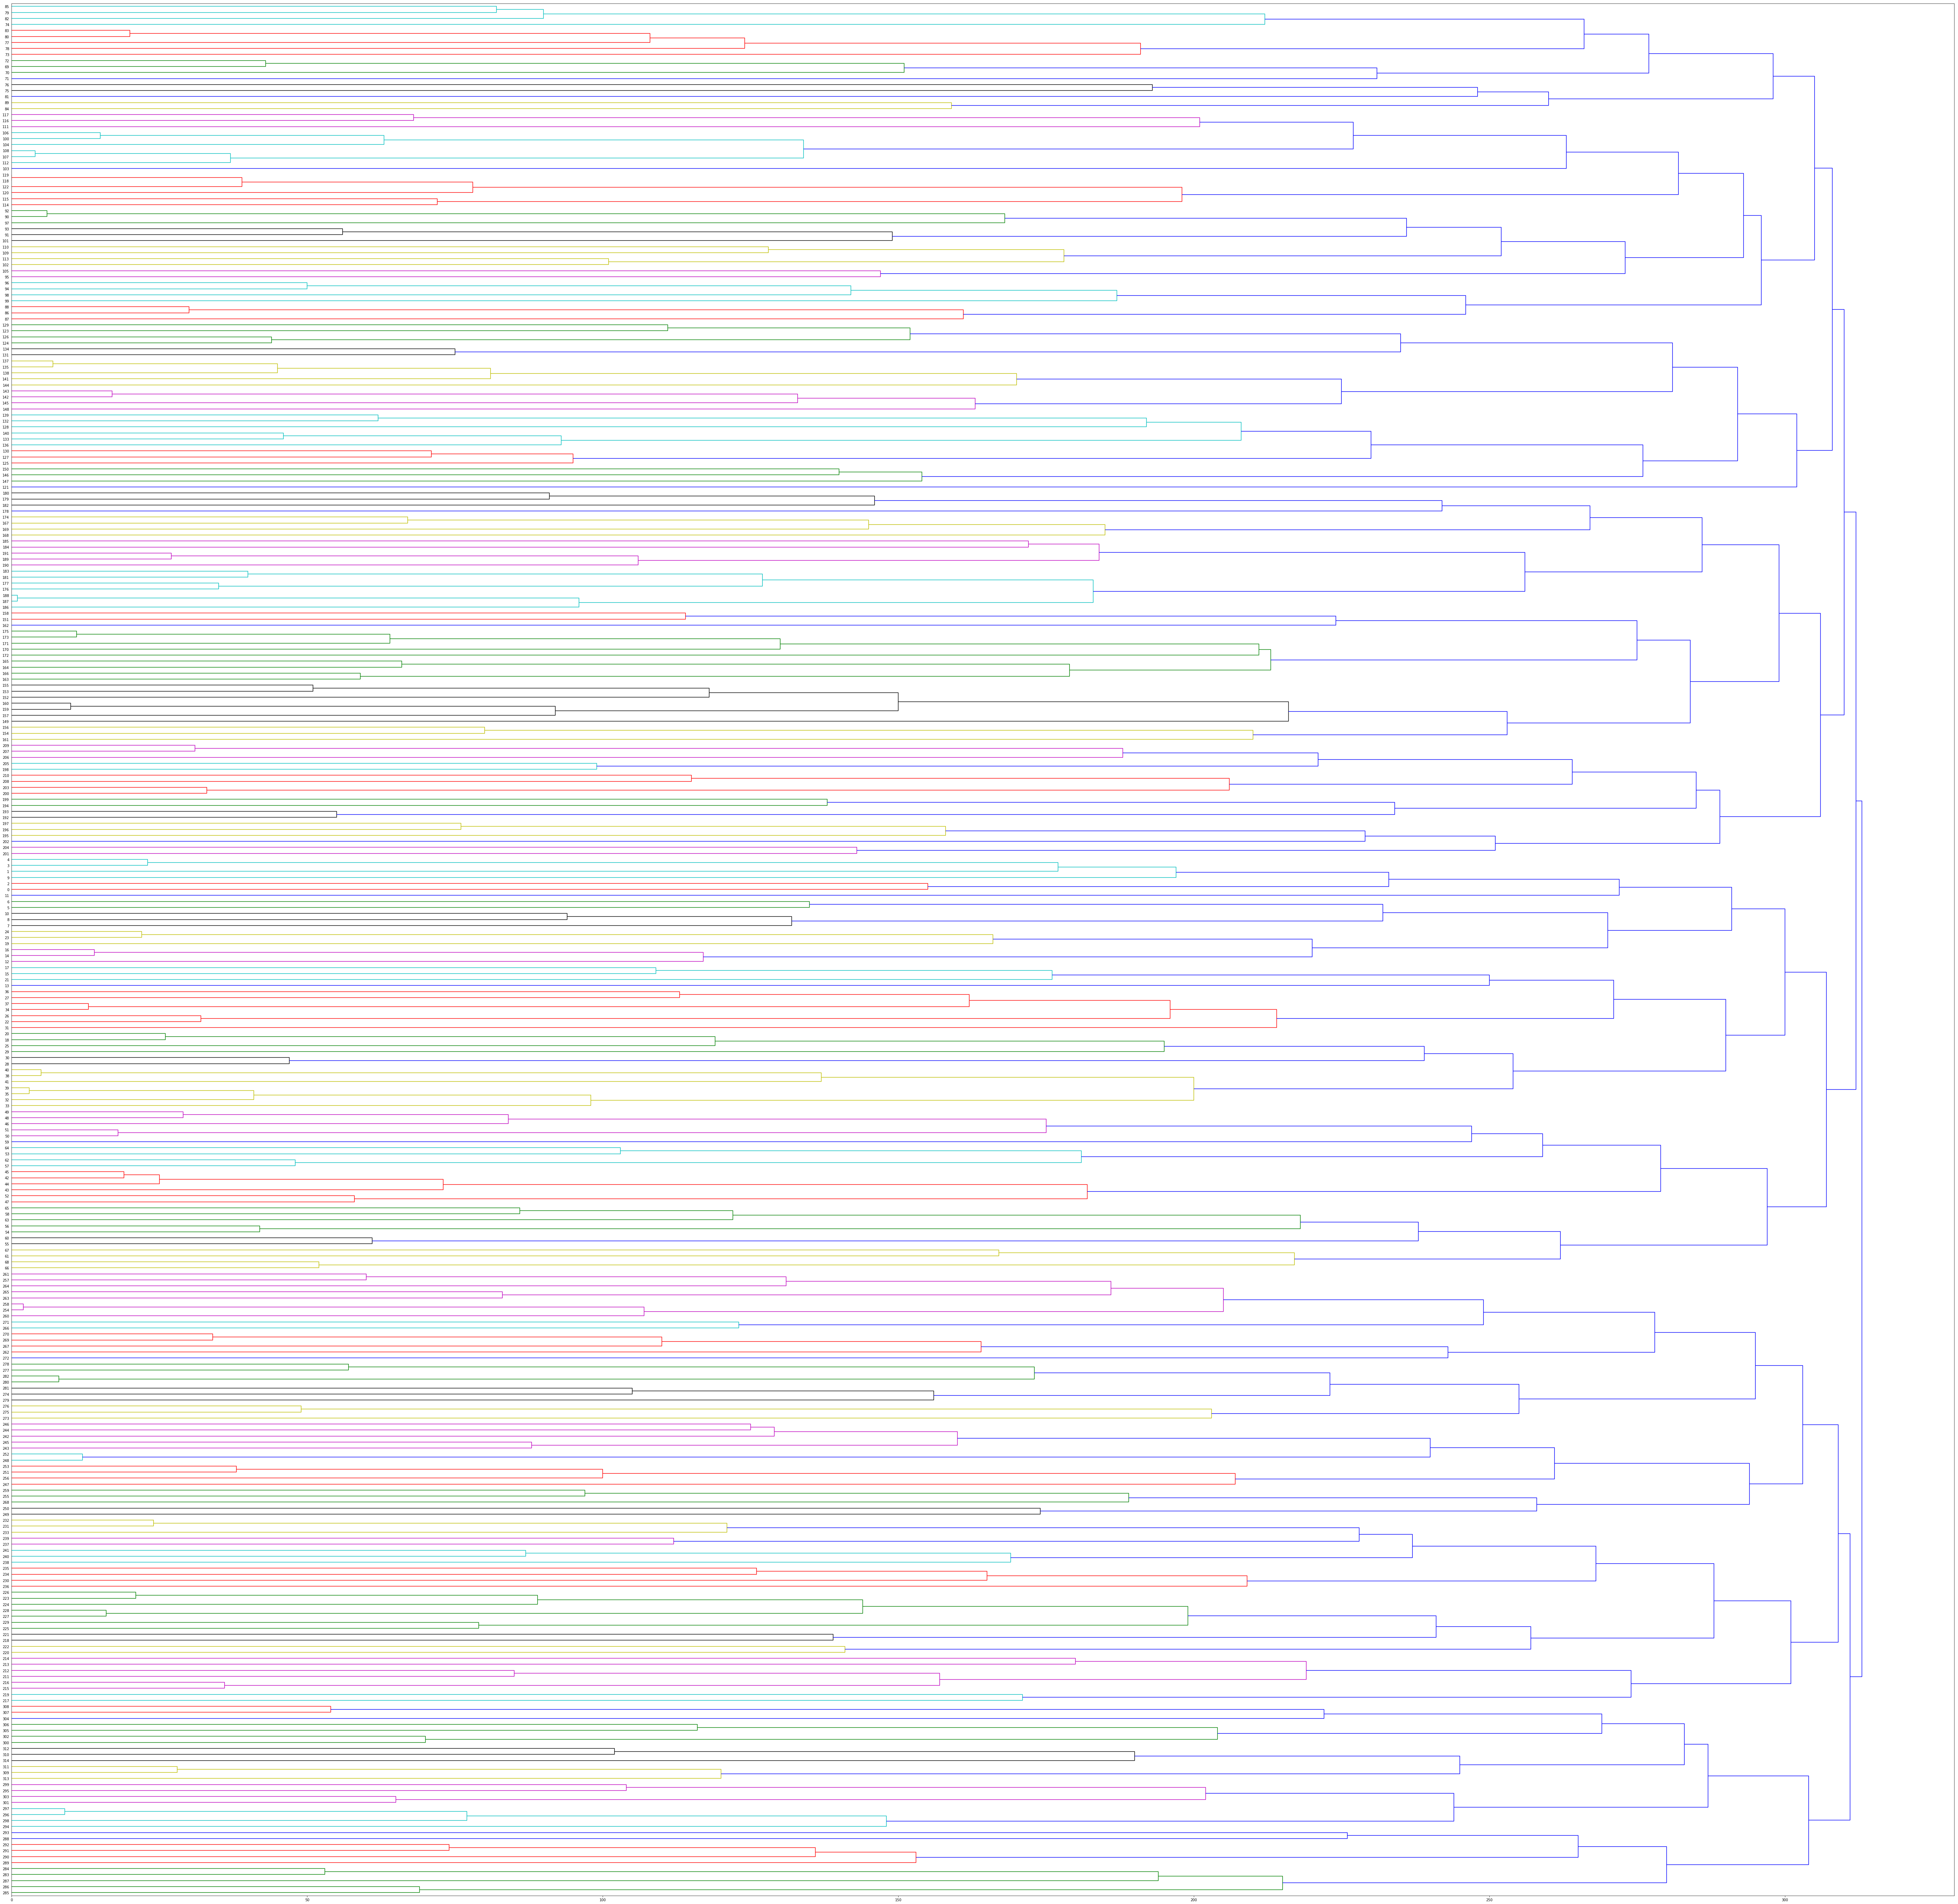

Zoom In Porcello and Scherzer


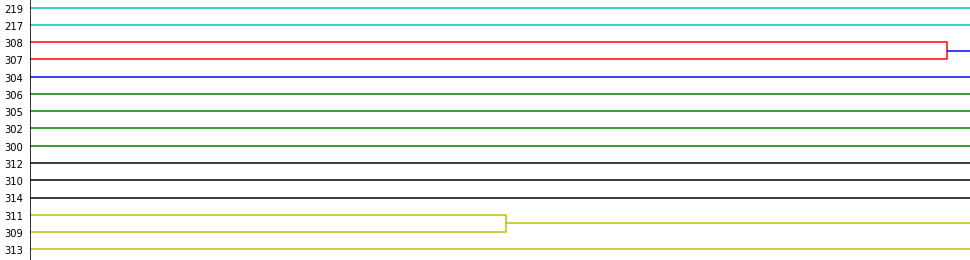

In [70]:
##Credit To:  https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
#from scipy.cluster.hierarchy import dendrogram

#plt.figure(figsize=(100,100))
#children = hac_fam.children_
#distance = np.arange(children.shape[0])
#no_of_observations = np.arange(2, children.shape[0]+2)
#linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
#dendrogram(linkage_matrix, labels=hacClust.index, show_leaf_counts=False, orientation='right', leaf_font_size=10)

plots = ["./plots/hacdend.png", "./plots/hacdendzoom.png"]
titles = ["Full Recluster Dendrogram", "Zoom In Porcello and Scherzer"]

for r in range(0,2):
    print(titles[r])
    display(Image.open(plots[r]))

As can be seen in the figure above, Porcello and Scherzer are in the same branch level 5 family along with twelve other pitchers.  These pitchers are shown below.  This is a fairly elite grouping of pitchers containing Matt Bumgardner, Johnny Cueto, Chris Sale and Justin Verlander.  Several of the names discussed in the Spectral Clustering section such as Luis Severino, Clayton Richards and Marcus Stromman exist in this group as well.  New pitchers not identified by Spectral Clustering are Julio Teheran, Mashahiro Tanaka, Jason Vargas and Ervin Santana.  

These are all pitchers with an extensive professional baseball resume.  They would all be targets for teams looking to bolster their pitching staffs for a playoff run or for a one or two year contract.  With regards to Luis Severino, he is the only pitcher who shares a leaf level group with Matt Scherzer.  This underscores his ability and potential.  With a sub \$1 Million salary, Severino is a incredible value and should be a target for every major league team once he becomes a free agent.

In [71]:
#Find automatic way to find similar pitchers from dendrogram
simPitch = [217, 219, 308, 307, 304, 306, 305, 302, 300, 312, 310, 314, 311, 307, 313]

hacClust.iloc[[217, 219, 308, 304, 306, 305, 302, 312, 310, 314, 311, 313]]

index   W   L   G  GS  CG  SHO  SV  IPouts    H      ...       GIDP  \
217  17702  15   9  34  34   4    1   0     680  179      ...       15.0   
219  17760  18   5  32  32   5    2   0     659  195      ...       13.0   
308  18981  14   6  31  31   0    0   0     580  150      ...       11.0   
304  18961  17   8  32  32   1    0   0     643  165      ...       11.0   
306  18967  16   8  33  33   5    3   0     634  177      ...        8.0   
305  18962   9  15  32  32   1    1   0     623  204      ...       11.0   
302  18921   8  15  32  32   2    1   0     592  240      ...       32.0   
312  19037  11  13  32  32   0    0   0     565  186      ...       15.0   
310  19025  13   9  33  33   2    0   0     603  201      ...       34.0   
314  19063  15   8  33  33   0    0   0     618  170      ...       12.0   
311  19034  13  12  30  30   1    1   0     535  180      ...       15.0   
313  19059  18  11  32  32   1    1   0     539  181      ...       22.0   

     yearID  throws_L  throws_R  throws_S  yearID  count1   playerID  \
217    2016         1         0         0    2016       1  bumgama01   
219    2016         0         1         0    2016       1  cuetojo01   
308    2017         0         1         0    2017       1  severlu01   
304    2017         1         0         0    2017       1   salech01   
306    2017         0         1         0    2017       1  santaer01   
305    2017         0         1         0    2017       1  samarje01   
302    2017         1         0         0    2017       1  richacl01   
312    2017         0         1         0    2017       1  teherju01   
310    2017         0         1         0    2017       1  stromma01   
314    2017         0         1         0    2017       1  verlaju01   
311    2017         0         1         0    2017       1  tanakma01   
313    2017         1         0         0    2017       1  vargaja01   

         salary    adjSalary2  
217   9916667.0  1.012492e+07  
219  17500000.0  1.786750e+07  
308         0.0  5.350000e+05  
304         0.0  5.350000e+05  
306         0.0  5.350000e+05  
305         0.0  5.350000e+05  
302         0.0  5.350000e+05  
312         0.0  5.350000e+05  
310         0.0  5.350000e+05  
314         0.0  5.350000e+05  
311         0.0  5.350000e+05  
313         0.0  5.350000e+05  

[12 rows x 35 columns]

#### Summary
The result of pitcher clustering models could prove to be an asset to the front office of any Major League Team.  It could help drive decisions to release, sign or trade pitchers.  Though the clusters where fairly easy to interpret, practical baseball knowledge must be applied in addition to clustering results to make these decisions.  For example, Clayton Richards appearing in both the Spectral Clustering and HAC output does not necessarily mean a team should make an 8 figure salary offer to a journey-man pitcher with a fairly average resume.  Baseball specific domain knowledge must be combined with the results of clustering to make the best decisions.

---
## Deployment  

The clustering pitchers using Spectral Clustering and Hierarchical Agglomerative Clustering performed better than HDBSCAN and Gaussian Mixture models.  The best Spectral Clustering model has the advantage of producing an affinity matrix to make very granular comparisons of similar pitchers.  The best Hierarchical Agglomerative Clustering model produced results similar to the best Spectral Clustering model.  However, Hierarchical Agglomerative Clustering also produced a three cluster model which had a good silhouette score.  This enabled the analysis of clustered pitcher data using two different algorithms and numbers of clusters.  

Performance was acceptable with all models on this data set.  A two-VCPU cloud virtual machine with 8GM of RAM was used to for clustering.  The subset pitching data frame used for clustering resulted in very quick model generation and result production.  Tests were run using the entire pitcher population data back to 1984.  Though the models ran longer, it was to be expected and only pushed the VM VCPU utilization to approximately 40%.  

The clustering models were built in the cloud.  So, cloud deployment is an obvious option.  However, the size of this data set is not so large that is would necessitate an enterprise grade server cluster or significant cloud environment.  The data set itself would only need to be updated once or twice a year at most.  The technical deployment considerations are minimal.  Deploying and presenting the results to consumers is a different question.  As seen above, a giant dendrogram can’t simply be given to a general manager of a professional baseball team.  A filterable data table with similarity metrics or interactive dendrogram would be required to allow for individual player decisions.  

This study focused on finding pitchers similar to two of the game’s premier pitchers.  Though some interesting results were produced.  The real value of these models would be to assist baseball general managers in making decisions regarding more average pitchers.  For example, the middle reliever has become a key component of most pitching staffs.  These pitchers are generally paid less and may not be as talented as starters or closers.  How can baseball management replace a good middle reliever with someone of equal ability, and how much should that person make?  The clustering tools can assist with answering those questions by showing similar pitchers who may be suitable replacements.  

Next steps to expand this model would be to integrate biomechanical and pitch specific data for pitchers.  Attributes just a type of pitch, average speed of pitch, average pitch spin rate, arm angle and other similar attributes could add a new dimension of clustering to allow managers to uncover potential future stars.  Additionally, this exercise focused on pitcher data per year.  It would be interesting to cluster pitchers based on career totals.  

---
## Exceptional Work